# Spectral_Curvature


=== microsoft/DialoGPT-medium ===


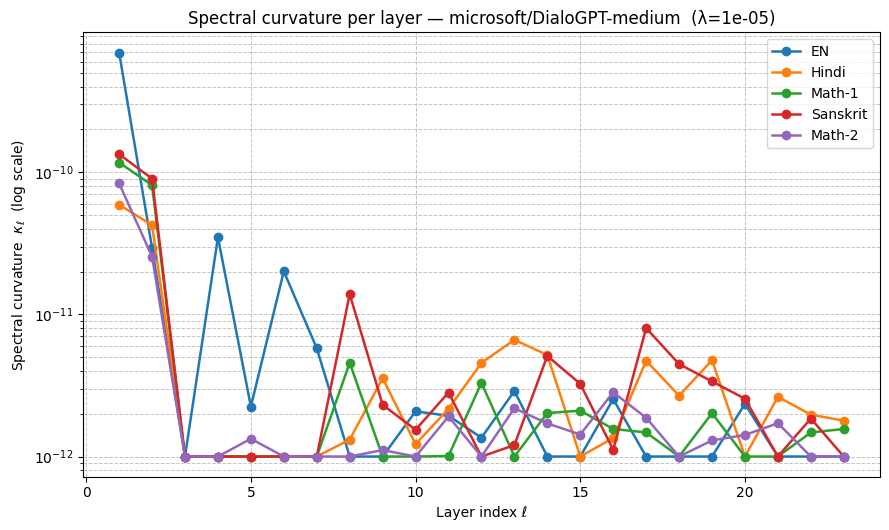

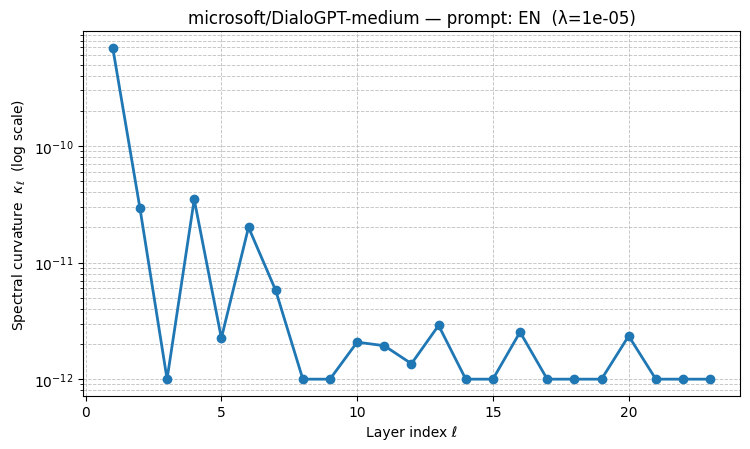

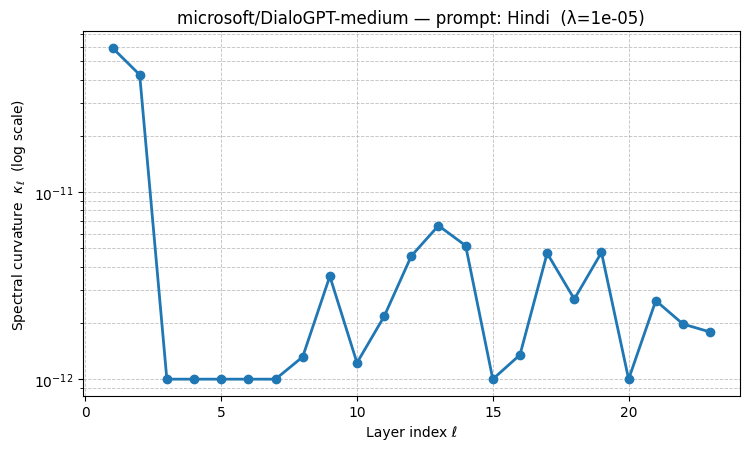

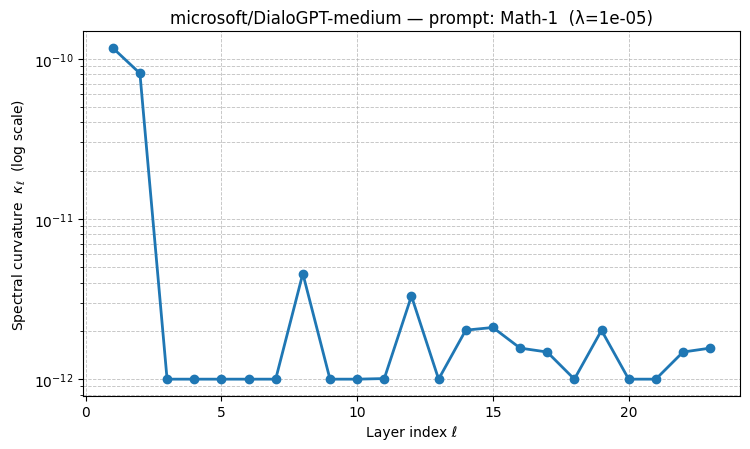

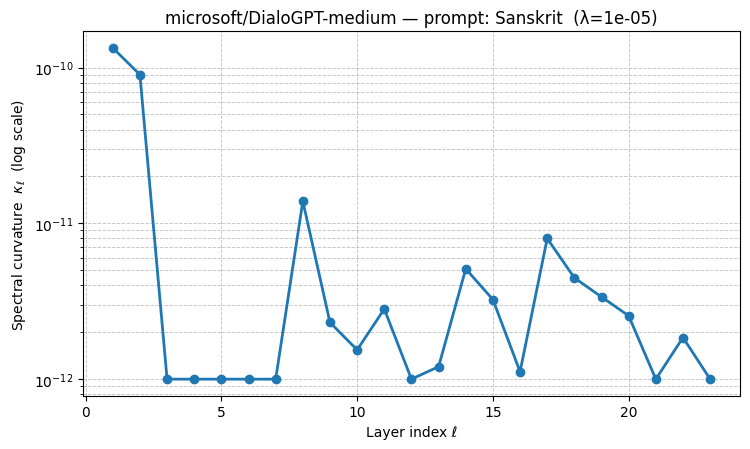

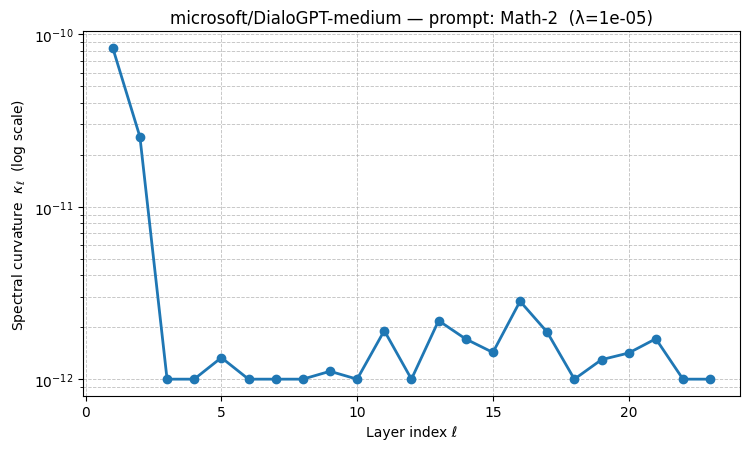


=== gpt2 ===


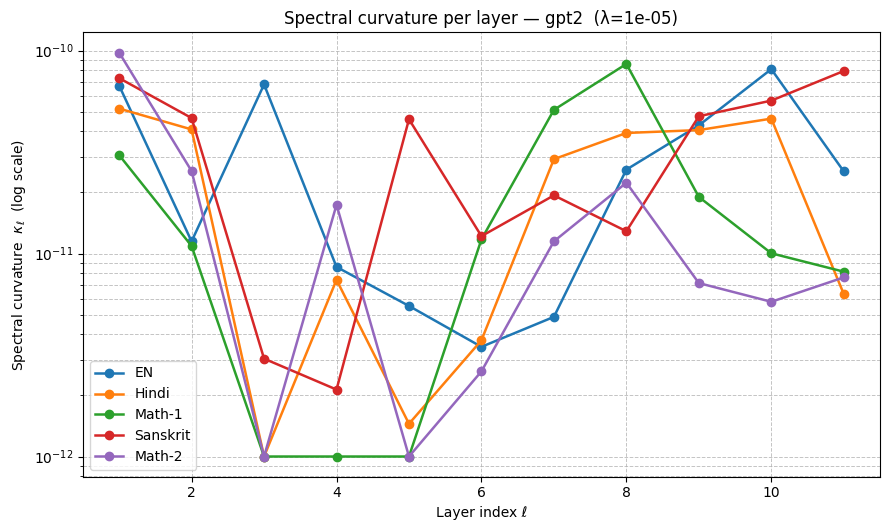

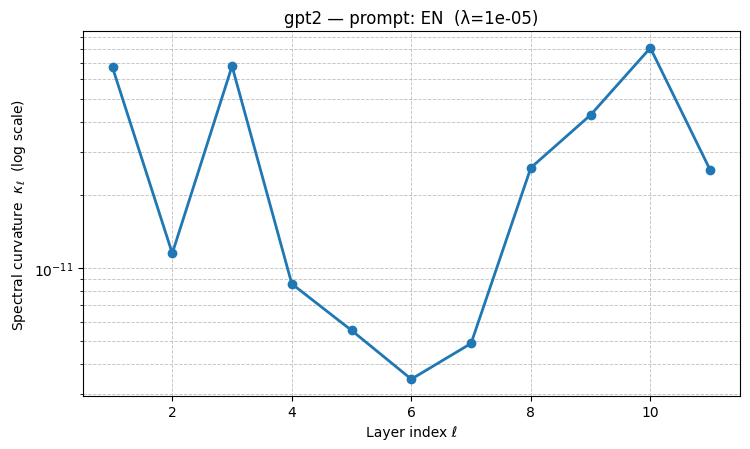

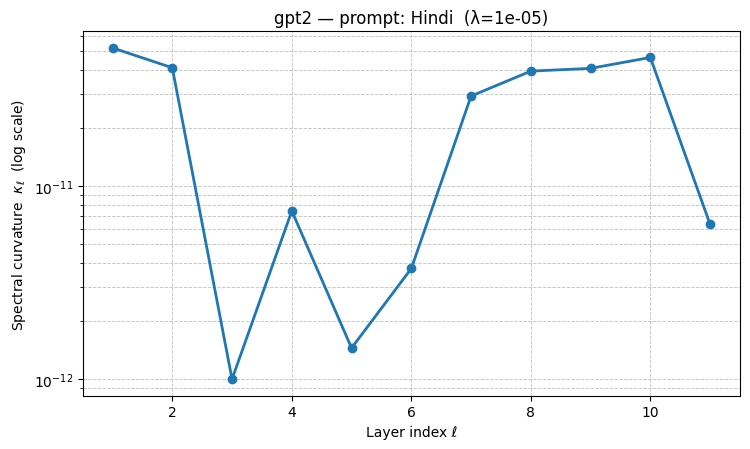

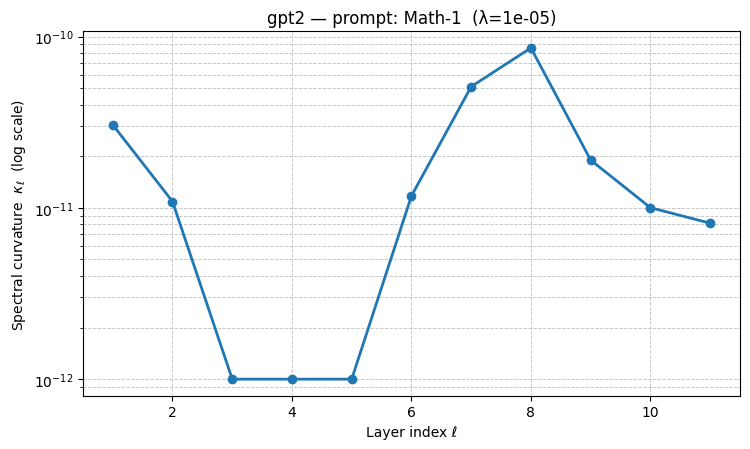

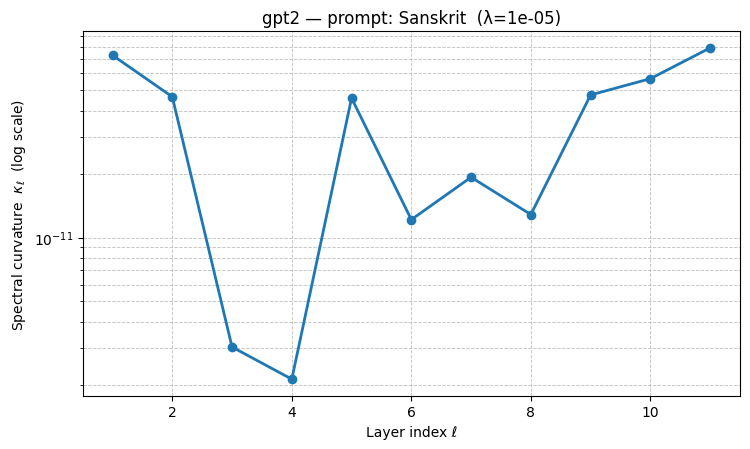

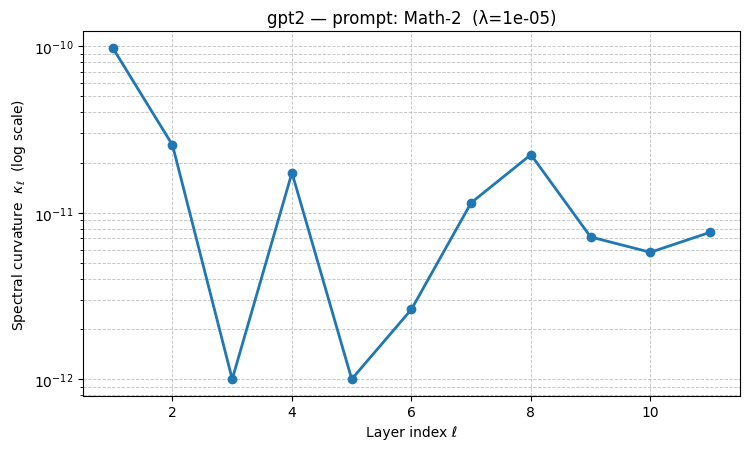


=== TinyLlama/TinyLlama-1.1B-Chat-v1.0 ===


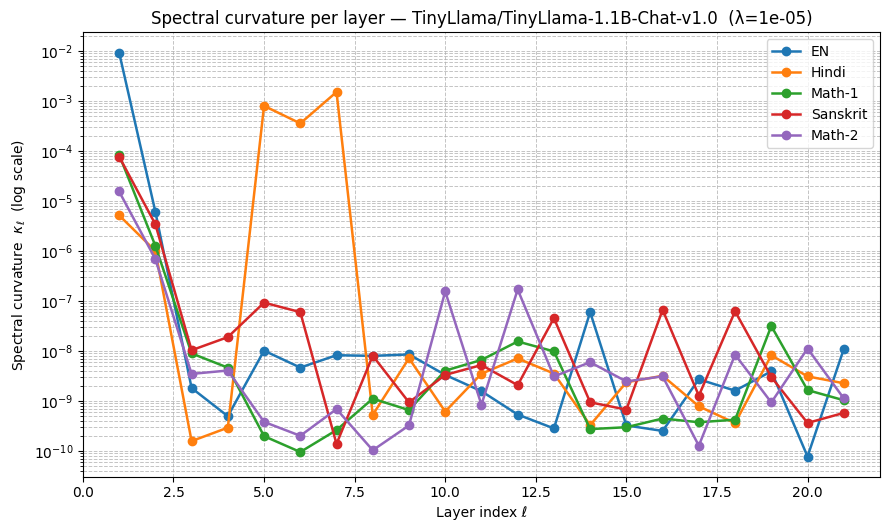

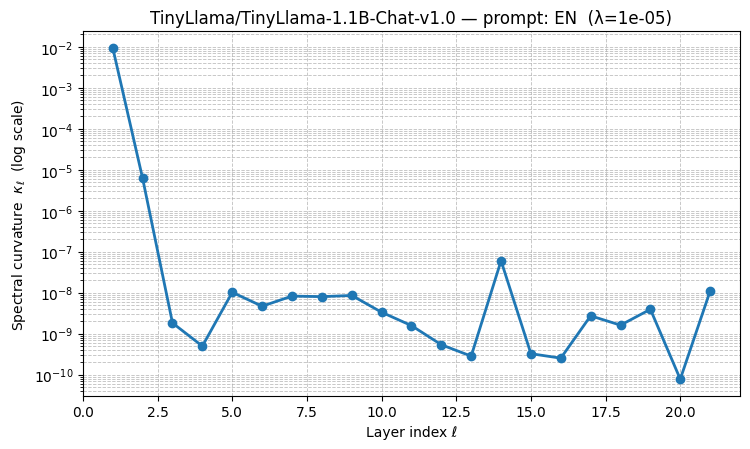

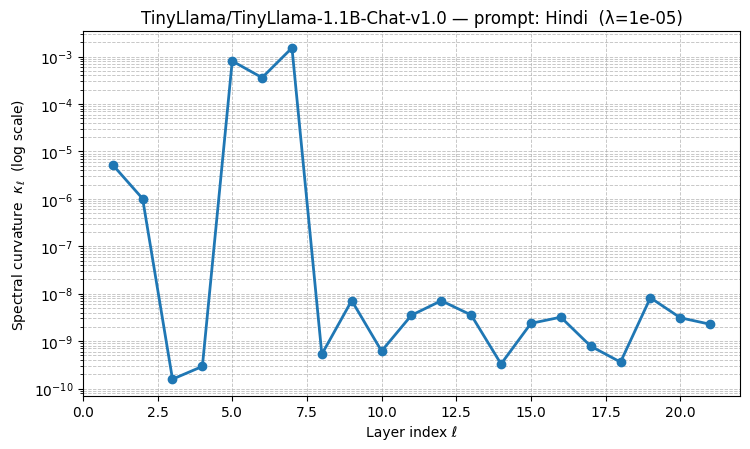

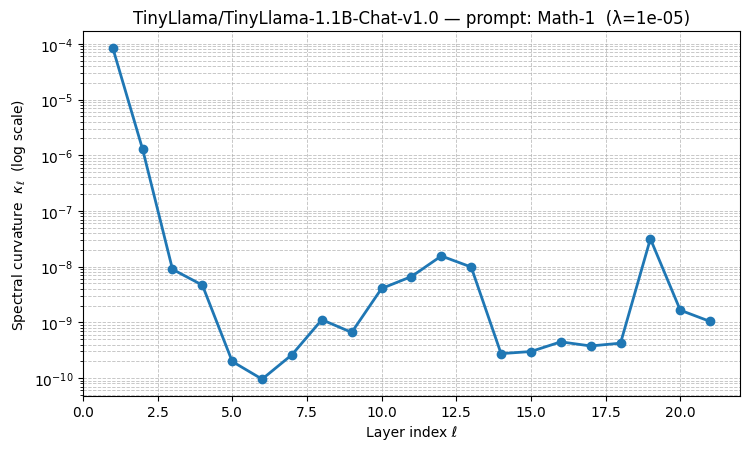

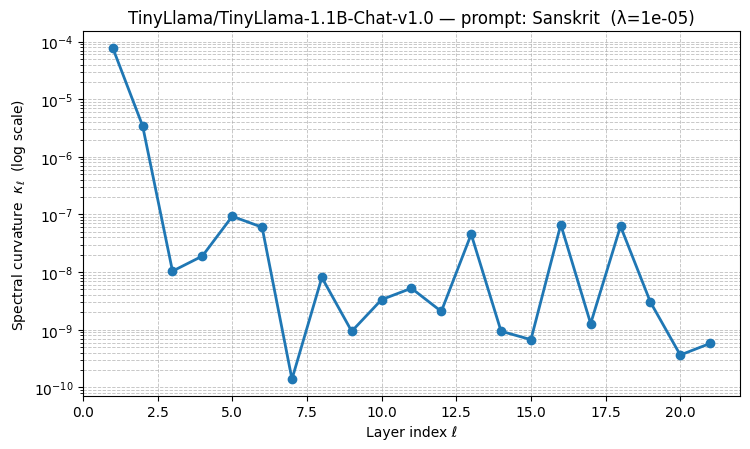

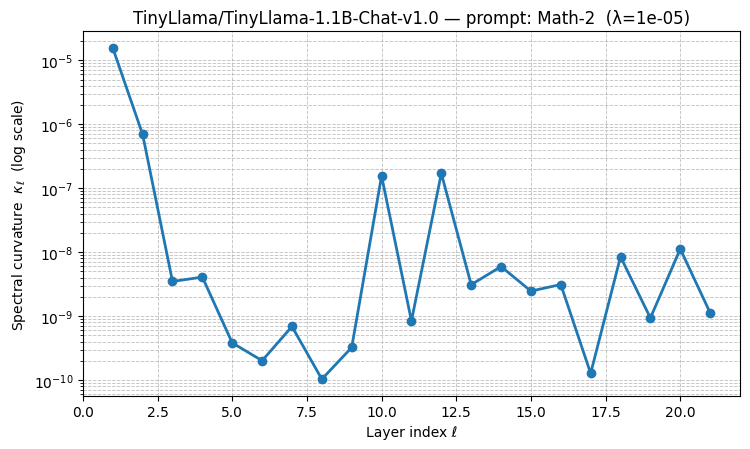

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

import logging
logging.getLogger("transformers").setLevel(logging.ERROR)
logging.getLogger("datasets").setLevel(logging.ERROR)

from transformers.utils import logging as hf_logging
hf_logging.set_verbosity_error()
hf_logging.disable_progress_bar()

import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
from transformers.utils import logging
logging.disable_progress_bar()


# Config
MODELS = [
    "microsoft/DialoGPT-medium",
    "gpt2",
    "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
]

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float32            # keep float32 for stable SVD/eigh
RIDGE_LAMBDA = 1e-5              # λ > 0 recommended for stability
EPS = 1e-8                       # ε for curvature denominator
MAX_LEN = 256
LOG_Y = True                     # plot κ on log scale

PROMPTS = [
    "The artist drew a landscape with a river flowing towards the mountains.",
    "इसे आज़माने के लिए, नीचे अपनी भाषा और इनपुट उपकरण चुनें और लिखना आरंभ करें|",
    r"**The CS- Inequality**\$$\left( \sum_{k=1}^n a_k b_k \right)^2 \leq \left( \sum_{k=1}^n a_k^2 \right) \left( \sum_{k=1}^n b_k^2 \right)$$",
    "श्वः अतीव द्रुतं धावति",
    r"Z = \int \mathcal{D}\phi \, \exp \left( i \int d^4x \, \sqrt{-g(x)} \left[ \frac{1}{2} g^{\mu\nu}(x) \partial_\mu \phi(x) \, \partial_\nu \phi(x) - \frac{1}{2} m^2 \phi^2(x) - \frac{\lambda}{4!} \phi^4(x) + \frac{1}{16\pi G} (R(x) - 2\Lambda) \right] \right)"
]

SHORT_LABELS = [
    "EN",
    "Hindi",
    "Math-1",
    "Sanskrit",
    "Math-2",
]


# Linear algebra helpers
@torch.no_grad()
def center_rows(X: torch.Tensor) -> torch.Tensor:
    # X: [N, d]
    return X - X.mean(dim=0, keepdim=True)

@torch.no_grad()
def sym_inv_sqrt_spd(Sigma: torch.Tensor) -> torch.Tensor:
    # Sigma: [d, d], SPD
    evals, evecs = torch.linalg.eigh(Sigma)
    evals = torch.clamp(evals, min=1e-12)
    return evecs @ torch.diag_embed(evals.rsqrt()) @ evecs.transpose(-1, -2)

@torch.no_grad()
def polar_orthogonal(C: torch.Tensor) -> torch.Tensor:
    # Orthogonal factor of polar decomposition via SVD
    # C = U S V^T  =>  R = U V^T
    U, S, Vh = torch.linalg.svd(C, full_matrices=False)
    R = U @ Vh
    # Ensure proper rotation (optional; usually unnecessary)
    if torch.det(R) < 0:
        U = U.clone()
        U[:, -1] *= -1
        R = U @ Vh
    return R


# Per-prompt spectral curvature evaluator
@torch.no_grad()
def spectral_curvature_per_prompt(hidden_states, attn_mask, ridge_lambda=RIDGE_LAMBDA):
    """
    hidden_states: list length (n_layers+1) of [B, T, d] tensors
    attn_mask: [B, T]
    Returns: callable per_b(b) -> list (length n_layers-1) of κ_ell for prompt index b
    """
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

    B, T, d = hidden_states[0].shape
    n_layers = len(hidden_states) - 1

    def per_b(b: int):
        mask_b = attn_mask[b].bool()                      # [T]
        N = int(mask_b.sum().item())
        assert N > 1, "Prompt produced fewer than 2 tokens; increase MAX_LEN or check tokenizer."

        # Build X_ell for all layers for this prompt, row-centered
        X_layers = []
        for L in range(n_layers + 1):
            H_b = hidden_states[L][b]                     # [T, d]
            X = H_b[mask_b]                               # [N, d]
            X = center_rows(X.to(DTYPE))
            X_layers.append(X)

        # Σ_ell^{-1/2} with ridge
        I = torch.eye(d, device=X_layers[0].device, dtype=DTYPE)
        Sigma_inv_sqrts = []
        for L in range(n_layers + 1):
            X = X_layers[L]                               # [N, d]
            Sigma = (X.T @ X) / float(N)
            if ridge_lambda > 0.0:
                Sigma = Sigma + ridge_lambda * I
            Sigma_inv_sqrts.append(sym_inv_sqrt_spd(Sigma))

        # Procrustes R_ell from C_ell = (1/N) X_ell^T X_{ell+1}
        Rs = []
        for L in range(n_layers):
            C = (X_layers[L].T @ X_layers[L + 1]) / float(N)  # [d, d]
            Rs.append(polar_orthogonal(C))

        # κ_ell for ell = 1..n_layers-1
        curv = []
        for ell in range(1, n_layers):
            X_prev, X_cur, X_next = X_layers[ell - 1], X_layers[ell], X_layers[ell + 1]
            R_prev, R_cur = Rs[ell - 1], Rs[ell]

            # Transport neighbors into frame of ell
            X_prev_to_cur = X_prev @ R_prev               # (ell-1) -> ell
            X_next_to_cur = X_next @ R_cur.T              # (ell+1) -> ell

            # Discrete first and second differences
            Delta  = X_next_to_cur - X_cur
            Delta2 = X_next_to_cur - 2.0 * X_cur + X_prev_to_cur

            # Whiten in Σ_ell^{-1/2} metric
            Sinv = Sigma_inv_sqrts[ell]
            Dh  = Delta  @ Sinv
            D2h = Delta2 @ Sinv

            # Frenet-style normalization
            s = torch.linalg.norm(Dh, ord="fro")
            kappa = torch.linalg.norm(D2h, ord="fro") / ((s * s + EPS) ** 1.5)  # == ||D2h||_F / (||Dh||_F^3 + tiny)
            curv.append(float(kappa))

        return curv

    return per_b

# Run for a single model
def run_model(model_name: str):
    print(f"\n=== {model_name} ===")
    config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
    config.output_hidden_states = True

    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, trust_remote_code=True)
    if tokenizer.pad_token_id is None:
        tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelForCausalLM.from_pretrained(model_name, config=config, trust_remote_code=True).to(DEVICE).eval()

    # Tokenize prompts together (single forward for efficiency)
    enc = tokenizer(PROMPTS, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
    input_ids = enc["input_ids"].to(DEVICE)
    attention_mask = enc["attention_mask"].to(DEVICE)

    with torch.no_grad():
        out = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            use_cache=False,
            return_dict=True,
        )

    hidden_states = [hs.to(DEVICE).to(DTYPE) for hs in out.hidden_states]  # list length n_layers+1, each [B,T,d]
    n_layers = len(hidden_states) - 1
    x = list(range(1, n_layers))  # κ_ell defined for ell = 1..n_layers-1

    # Build per-prompt evaluator and compute κ-curves
    per_prompt_fn = spectral_curvature_per_prompt(hidden_states, attention_mask, RIDGE_LAMBDA)
    kappa_curves = []
    for b in range(len(PROMPTS)):
        kappa_b = per_prompt_fn(b)
        kappa_curves.append(kappa_b)

    # Plot: spectral curvature across layers, all prompts (log y if desired)
    plt.figure(figsize=(9.0, 5.4))
    for kappa_b, label in zip(kappa_curves, SHORT_LABELS):
        y = [max(v, 1e-12) for v in kappa_b]  # guard for log
        plt.plot(x, y, marker="o", linewidth=1.8, label=label)
    if LOG_Y:
        plt.yscale("log")
    plt.xlabel("Layer index ℓ")
    plt.ylabel("Spectral curvature  $\\kappa_\\ell$" + ("  (log scale)" if LOG_Y else ""))
    plt.title(f"Spectral curvature per layer — {model_name}  (λ={RIDGE_LAMBDA})")
    plt.grid(True, which="both", linestyle="--", linewidth=0.7, alpha=0.75)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Also show each prompt’s curve separately (no saving)
    for label, kappa_b in zip(SHORT_LABELS, kappa_curves):
        y = [max(v, 1e-12) for v in kappa_b]
        plt.figure(figsize=(7.6, 4.6))
        plt.plot(x, y, marker="o", linewidth=2.0)
        if LOG_Y:
            plt.yscale("log")
        plt.xlabel("Layer index ℓ")
        plt.ylabel("Spectral curvature  $\\kappa_\\ell$" + ("  (log scale)" if LOG_Y else ""))
        plt.title(f"{model_name} — prompt: {label}  (λ={RIDGE_LAMBDA})")
        plt.grid(True, which="both", linestyle="--", linewidth=0.65, alpha=0.75)
        plt.tight_layout()
        plt.show()

    # Free memory between models
    del model
    if DEVICE == "cuda":
        torch.cuda.empty_cache()

# -------------------------------
# Entry
# -------------------------------
if __name__ == "__main__":
    torch.set_grad_enabled(False)
    for m in MODELS:
        run_model(m)


# Thermodynamic Length


✅ Loaded TinyLlama/TinyLlama-1.1B-Chat-v1.0. Computing thermodynamic length...


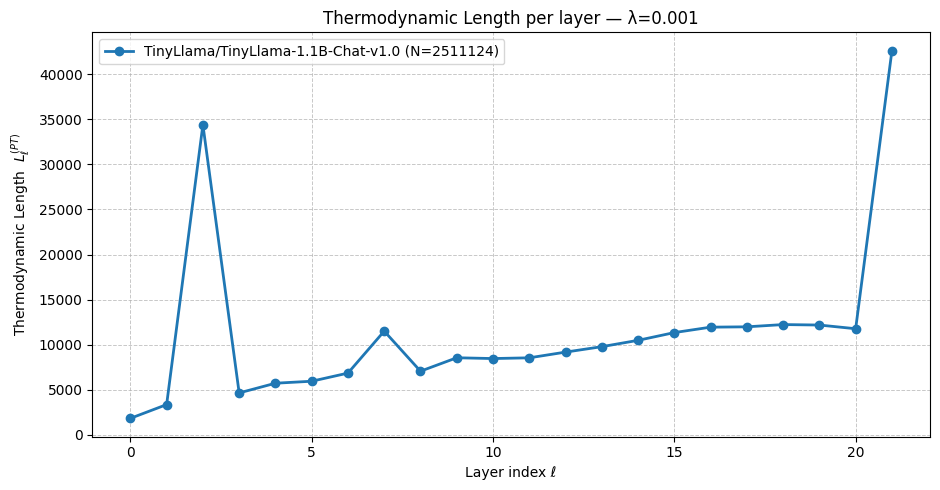

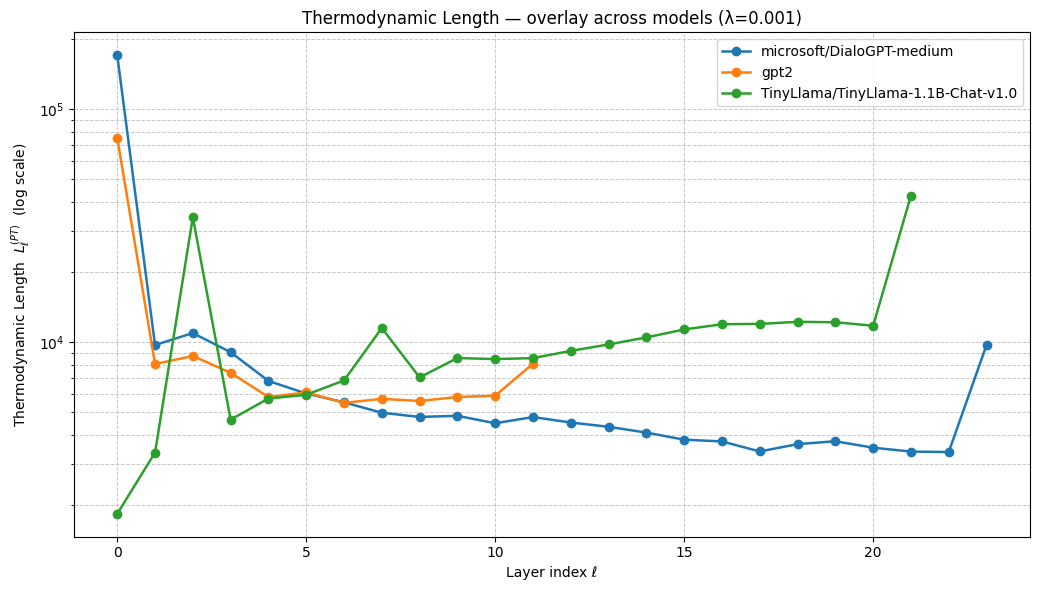

In [ ]:
import os
import math
import random
from dataclasses import dataclass
from typing import List, Dict, Tuple
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
from transformers.utils import logging  # <-- CHANGE: Import logging utility
from IPython.display import clear_output # <-- CHANGE: Import clear_output

# Config
MODELS = [
    "microsoft/DialoGPT-medium",
    "gpt2",
    "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
]

SPLIT         = "train"      # SQuAD split
NUM_EXAMPLES  = 512          # increase for smoother estimates
BATCH_SIZE    = 4            # tune for your GPU/CPU (keep small for 1.1B)
MAX_LENGTH    = 256          # truncate long context+question
RIDGE_LAMBDA  = 1e-3         # λ > 0 for stability in Σ^{-1/2}
SEED          = 1234
LOG_Y         = False        # set True to see log scale for L
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

# Forward precision for speed; all geometry in FP32
DTYPE_FW = (
    torch.bfloat16 if (DEVICE == "cuda" and torch.cuda.is_bf16_supported())
    else (torch.float16 if DEVICE == "cuda" else torch.float32)
)
DTYPE_ACCUM = torch.float32  # do second-moment math in FP32 for stability


# Repro + Data
def set_seed(seed: int = 1234):
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

@dataclass
class Batch:
    input_ids: torch.Tensor
    attention_mask: torch.Tensor

def make_text_from_squad(example: Dict[str, str]) -> str:
    q = example["question"].strip().replace("\n", " ")
    c = example["context"].strip().replace("\n", " ")
    return f"Question: {q}\nContext: {c}\n"

def collate_fn_builder(tokenizer):
    def collate(batch_texts: List[str]) -> Batch:
        enc = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors="pt",
        )
        return Batch(
            input_ids=enc["input_ids"],
            attention_mask=enc["attention_mask"],
        )
    return collate


# LA helpers
@torch.no_grad()
def spd_inverse_sqrt(mat: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    # mat: (d, d) SPD -> mat^{-1/2}
    eigvals, eigvecs = torch.linalg.eigh(mat.to(DTYPE_ACCUM))
    eigvals = torch.clamp(eigvals, min=eps)
    inv_sqrt = eigvecs @ torch.diag(eigvals.rsqrt()) @ eigvecs.transpose(-1, -2)
    return inv_sqrt

@torch.no_grad()
def procrustes_rotation_from_C(C: torch.Tensor) -> torch.Tensor:
    # C = (1/N) X_ell^T X_{ell+1}; R = polar(C) = U V^T (closest orthogonal)
    U, S, Vh = torch.linalg.svd(C.to(DTYPE_ACCUM), full_matrices=False)  # C = U S Vh
    R = U @ Vh
    # Ensure proper rotation if det(R) == -1 (rare)
    if torch.det(R) < 0:
        U = U.clone()
        U[:, -1] *= -1
        R = U @ Vh
    return R


# Model-agnostic getters
def get_hidden_size(model) -> int:
    # GPT-2: n_embd ; LLaMA/TinyLlama: hidden_size
    return (getattr(model.config, "n_embd", None)
            or getattr(model.config, "hidden_size", None)
            or model.config.hidden_size)

def get_num_layers(model) -> int:
    # GPT-2: n_layer ; LLaMA/TinyLlama: num_hidden_layers
    return (getattr(model.config, "n_layer", None)
            or getattr(model.config, "num_hidden_layers", None)
            or model.config.num_hidden_layers)

# Core: streaming thermodynamic length
@torch.no_grad()
def compute_layer_lengths_streaming(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    dataloader: DataLoader,
    ridge_lambda: float = RIDGE_LAMBDA,
) -> Tuple[List[float], int]:
    model.eval()

    n_layers = get_num_layers(model)     # number of transitions (ell=0..n_layers-1)
    d_model  = get_hidden_size(model)

    # Accumulators for each layer ℓ
    A_sum = [torch.zeros((d_model, d_model), dtype=DTYPE_ACCUM, device=DEVICE) for _ in range(n_layers)]
    B_sum = [torch.zeros((d_model, d_model), dtype=DTYPE_ACCUM, device=DEVICE) for _ in range(n_layers)]
    C_sum = [torch.zeros((d_model, d_model), dtype=DTYPE_ACCUM, device=DEVICE) for _ in range(n_layers)]
    N_sum = [0 for _ in range(n_layers)]  # counts of valid tokens used per layer (same for ℓ and ℓ+1)

    # Forward pass over dataset
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")
    autocast_kwargs = {"device_type": "cuda", "dtype": DTYPE_FW} if DEVICE == "cuda" else {}
    ctx = torch.autocast if DEVICE == "cuda" else torch.cpu.amp.autocast  # type: ignore

    for batch in dataloader:
        input_ids = batch.input_ids.to(DEVICE)
        attention_mask = batch.attention_mask.to(DEVICE)
        # GPT-2 family needs pad_token_id set to eos_token_id for padding
        input_ids = input_ids.masked_fill(attention_mask.eq(0), tokenizer.pad_token_id)

        with ctx(**autocast_kwargs):  # type: ignore
            out = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                use_cache=False,
                output_hidden_states=True,
                return_dict=True,
            )
        hidden_states = out.hidden_states  # tuple length = n_layers+1 (includes embeddings at 0)

        # Flatten mask to pick valid tokens
        mask = attention_mask.to(torch.bool)
        Bsz, T = mask.shape

        # Process all layer pairs
        for ell in range(n_layers):
            Xl   = hidden_states[ell]       # (B, T, d)
            Xlp1 = hidden_states[ell + 1]   # (B, T, d)

            m = mask.view(Bsz * T)
            Xl2d   = Xl.view(Bsz * T, d_model)[m].to(DTYPE_ACCUM)
            Xlp12d = Xlp1.view(Bsz * T, d_model)[m].to(DTYPE_ACCUM)
            Nb = Xl2d.shape[0]
            if Nb == 0:
                continue

            # Row-center each layer separately (per batch, per layer)
            Xl2d   = Xl2d   - Xl2d.mean(dim=0, keepdim=True)
            Xlp12d = Xlp12d - Xlp12d.mean(dim=0, keepdim=True)

            # Accumulate second moments
            A_sum[ell] += Xl2d.transpose(0, 1) @ Xl2d
            B_sum[ell] += Xlp12d.transpose(0, 1) @ Xlp12d
            C_sum[ell] += Xl2d.transpose(0, 1) @ Xlp12d
            N_sum[ell] += Nb

    # Compute L per layer from accumulated moments
    L_list: List[float] = []
    eye = torch.eye(d_model, dtype=DTYPE_ACCUM, device=DEVICE)
    for ell in range(n_layers):
        N = N_sum[ell]
        if N == 0:
            L_list.append(float("nan"))
            continue

        A = A_sum[ell] / float(N)  # (d, d)
        B = B_sum[ell] / float(N)
        C = C_sum[ell] / float(N)

        # Make symmetric for numerical hygiene
        A = 0.5 * (A + A.transpose(0, 1))
        B = 0.5 * (B + B.transpose(0, 1))

        # Σ_ℓ = A + λI   (intrinsic metric at layer ℓ)
        Sigma = A + ridge_lambda * eye

        # Orthogonal transport via polar(C)
        R = procrustes_rotation_from_C(C)  # (d, d)

        # M = R B R^T - R C^T - C R^T + A
        M = R @ B @ R.transpose(0, 1) - R @ C.transpose(0, 1) - C @ R.transpose(0, 1) + A
        M = 0.5 * (M + M.transpose(0, 1))  # symmetrize

        # L^2 = N * tr( Σ^{-1/2} M Σ^{-1/2} )
        Sinv = spd_inverse_sqrt(Sigma)
        S_mid = Sinv @ M @ Sinv
        S_mid = 0.5 * (S_mid + S_mid.transpose(0, 1))  # symmetrize
        L2 = float(N) * float(torch.trace(S_mid).clamp_min(0.0))
        L = math.sqrt(max(L2, 0.0))
        L_list.append(L)

    total_tokens = sum(N_sum)
    return L_list, total_tokens


# Per-model run + plotting
def run_for_model(model_name: str, texts: List[str]) -> Tuple[List[float], int]:
    # <-- CHANGE: Entire function body is wrapped in try/finally
    try:
        # This message will show while loading and then be cleared
        print(f"\n========== {model_name} ==========")
        print(f"Loading tokenizer and model... This may take a moment.")

        tokenizer = AutoTokenizer.from_pretrained(model_name)
        if tokenizer.pad_token_id is None:
            tokenizer.pad_token = tokenizer.eos_token

        cfg = AutoConfig.from_pretrained(model_name)
        cfg.output_hidden_states = True
        model = AutoModelForCausalLM.from_pretrained(model_name, config=cfg)
        model.to(DEVICE).eval()

    finally:
        # This will clear the "Loading..." message above
        clear_output()

    # This message will appear after loading is complete and the cell is cleared
    print(f"\n✅ Loaded {model_name}. Computing thermodynamic length...")

    collate = collate_fn_builder(tokenizer)
    loader = DataLoader(
        texts,
        batch_size=BATCH_SIZE,
        shuffle=False,
        drop_last=False,
        num_workers=2 if os.name != "nt" else 0,
        pin_memory=(DEVICE == "cuda"),
        collate_fn=collate,
    )

    L_list, N_tokens = compute_layer_lengths_streaming(
        model=model,
        tokenizer=tokenizer,
        dataloader=loader,
        ridge_lambda=RIDGE_LAMBDA,
    )

    # Plot this model’s curve
    n_layers = get_num_layers(model)
    x = list(range(n_layers))
    y = [max(1e-12, float(v)) if (v is not None) else 1e-12 for v in L_list]  # guard for log/zeros
    plt.figure(figsize=(9.5, 5.0))
    plt.plot(x, y, marker="o", linewidth=2.0, label=f"{model_name} (N={N_tokens})")
    if LOG_Y:
        plt.yscale("log")
    plt.xlabel("Layer index ℓ")
    plt.ylabel("Thermodynamic Length  $L^{(PT)}_\\ell$" + ("  (log scale)" if LOG_Y else ""))
    plt.title(f"Thermodynamic Length per layer — λ={RIDGE_LAMBDA}")
    plt.grid(True, which="both", linestyle="--", linewidth=0.7, alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return L_list, N_tokens

# Entry
def main():
    set_seed(SEED)
    logging.disable_progress_bar()  # <-- CHANGE: Disable all HF progress bars globally

    # Load SQuAD and build texts
    ds = load_dataset("squad", split=SPLIT)
    if NUM_EXAMPLES is not None:
        ds = ds.select(range(min(NUM_EXAMPLES, len(ds))))
    texts = [make_text_from_squad(ex) for ex in ds]

    # Run each model and also prepare overlay data
    overlay: Dict[str, List[float]] = {}
    x_axes: Dict[str, List[int]] = {}

    for model_name in MODELS:
        L_list, N_tokens = run_for_model(model_name, texts)
        overlay[model_name] = [max(1e-12, float(v)) if (v is not None) else 1e-12 for v in L_list]

        cfg = AutoConfig.from_pretrained(model_name)
        n_layers = (getattr(cfg, "n_layer", None)
                    or getattr(cfg, "num_hidden_layers", None)
                    or cfg.num_hidden_layers)
        x_axes[model_name] = list(range(n_layers))

    # Overlay plot across models — y in LOG scale
    plt.figure(figsize=(10.5, 6.0))
    for model_name, y in overlay.items():
        x = x_axes[model_name]
        y_plot = [max(1e-12, float(v)) for v in y]
        plt.plot(x, y_plot, marker="o", linewidth=1.8, label=model_name)

    plt.yscale("log")
    plt.xlabel("Layer index ℓ")
    plt.ylabel("Thermodynamic Length  $L^{(PT)}_\\ell$  (log scale)")
    plt.title(f"Thermodynamic Length — overlay across models (λ={RIDGE_LAMBDA})")
    plt.grid(True, which="both", linestyle="--", linewidth=0.7, alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()

# Belief Vector Fields

## Belief Vector Fields (Without any concept classes)


========== microsoft/DialoGPT-medium ==========
Estimating Σ_ℓ^{-1/2} ...
Computing belief vectors v_ℓ ...


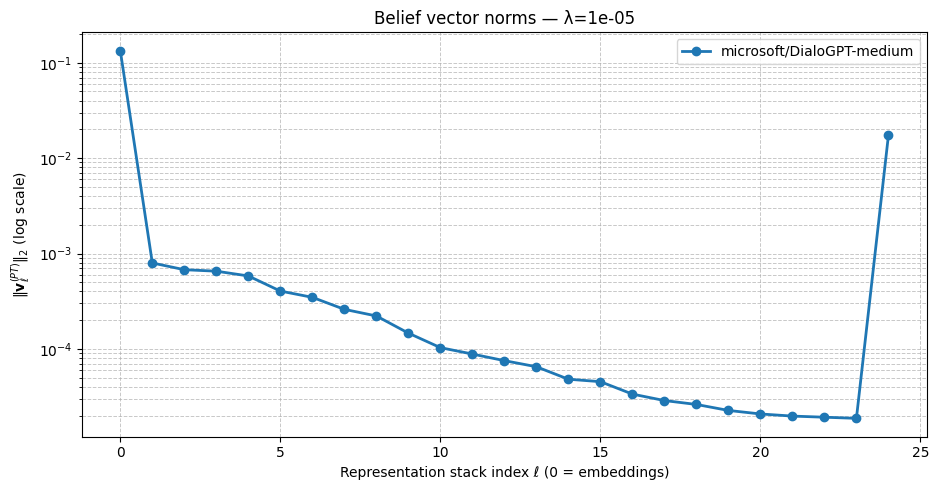


========== gpt2 ==========
Estimating Σ_ℓ^{-1/2} ...
Computing belief vectors v_ℓ ...


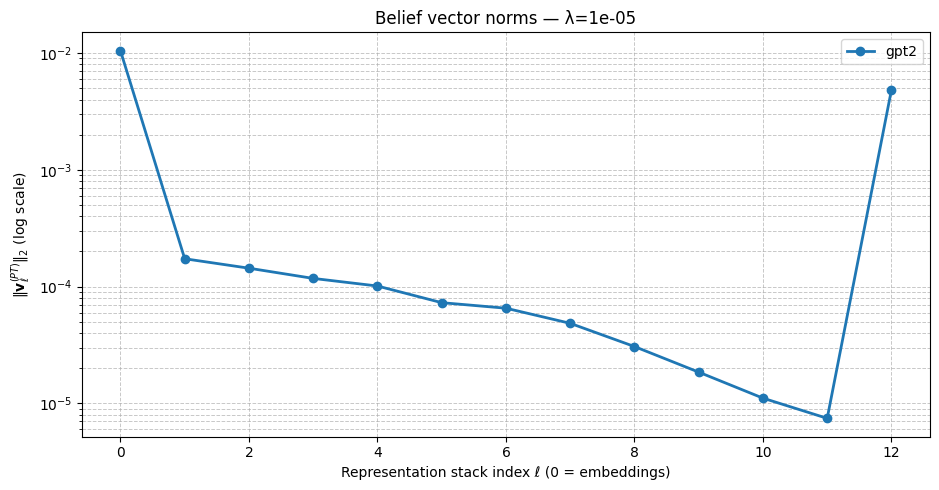


========== TinyLlama/TinyLlama-1.1B-Chat-v1.0 ==========
Estimating Σ_ℓ^{-1/2} ...
Computing belief vectors v_ℓ ...


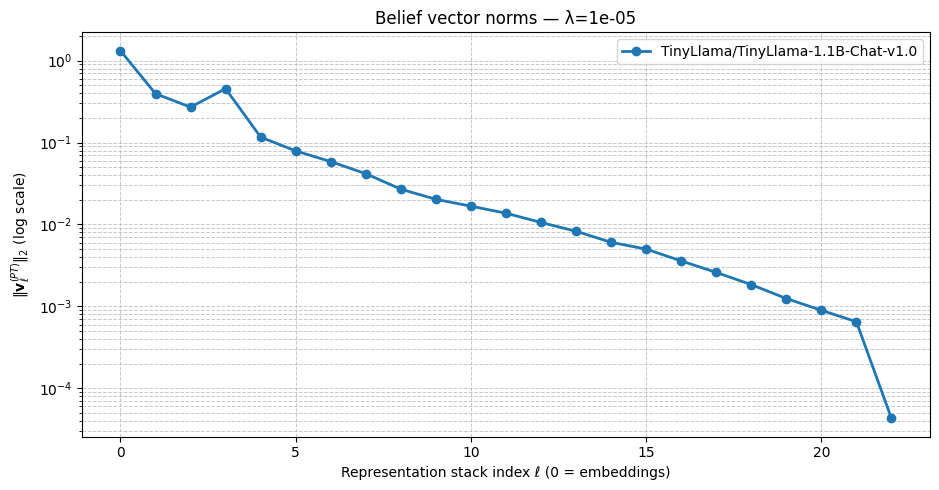

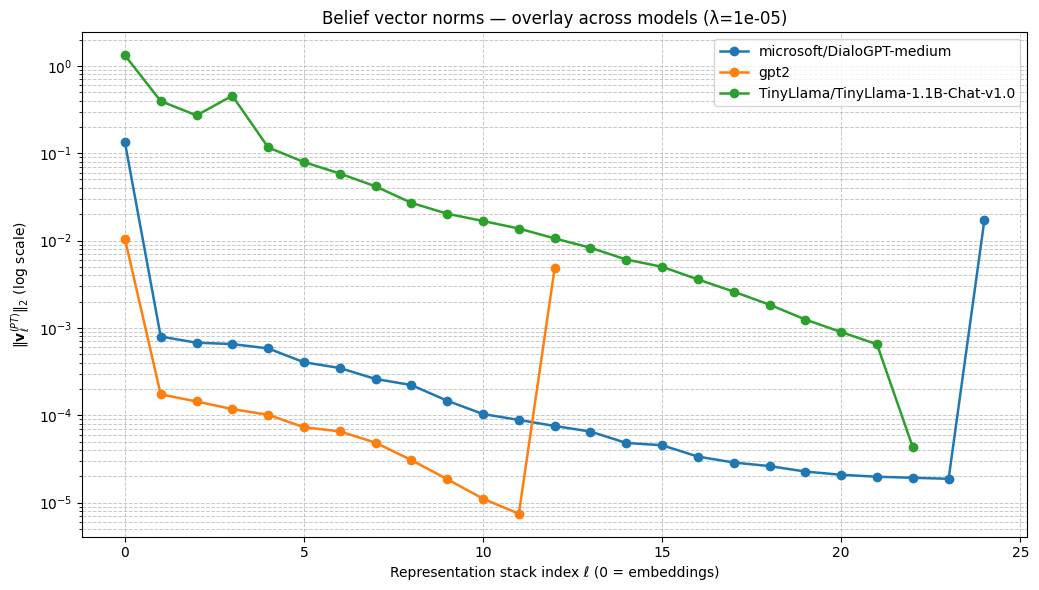

In [ ]:
import math
import random
from dataclasses import dataclass
from typing import List, Dict, Optional

import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM

# Config
MODELS = [
    "microsoft/DialoGPT-medium",
    "gpt2",
    "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
]
SPLIT         = "train"
NUM_EXAMPLES  = 512            # increase for smoother, but slower
BATCH_SIZE    = 2              # small for memory safety (esp. TinyLlama)
MAX_LENGTH    = 192
RIDGE_LAMBDA  = 1e-5           # ridge for Σ^{-1/2}
SEED          = 1234
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

# Forward precision for speed; geometry and pooling in FP32
DTYPE_FW      = (torch.bfloat16 if (DEVICE == "cuda" and torch.cuda.is_bf16_supported())
                 else (torch.float16 if DEVICE == "cuda" else torch.float32))
DTYPE_ACCUM   = torch.float32

# Optionally restrict to a subset of stacks (0=embeddings), e.g. [0, 6, 12]
LAYER_INDICES: Optional[List[int]] = None

# For log plots
EPS_LOG = 1e-16

# Data helpers
def set_seed(seed: int = 1234):
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    if hasattr(torch, "set_float32_matmul_precision"):
        torch.set_float32_matmul_precision("high")

@dataclass
class Batch:
    input_ids: torch.Tensor
    attention_mask: torch.Tensor

def make_text_from_squad(example: Dict[str, str]) -> str:
    q = example["question"].strip().replace("\n", " ")
    c = example["context"].strip().replace("\n", " ")
    return f"Question: {q}\nContext: {c}\n"

def collate_fn_builder(tokenizer):
    def collate(batch_texts: List[str]) -> Batch:
        enc = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors="pt",
        )
        return Batch(input_ids=enc["input_ids"], attention_mask=enc["attention_mask"])
    return collate

# Linear algebra
@torch.no_grad()
def spd_inverse_sqrt(mat: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    eigvals, eigvecs = torch.linalg.eigh(mat.to(DTYPE_ACCUM))
    eigvals = torch.clamp(eigvals, min=eps)
    return eigvecs @ torch.diag(eigvals.rsqrt()) @ eigvecs.transpose(-1, -2)

# Model-agnostic helpers
def get_hidden_size(model) -> int:
    return (getattr(model.config, "n_embd", None)
            or getattr(model.config, "hidden_size", None)
            or model.config.hidden_size)

def get_num_layers(model) -> int:
    return (getattr(model.config, "n_layer", None)
            or getattr(model.config, "num_hidden_layers", None)
            or model.config.num_hidden_layers)

# Pass 1: estimate Σ_ℓ^{-1/2} with global centering
@torch.no_grad()
def estimate_sigma_inv_sqrts(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    dataloader: DataLoader,
    ridge_lambda: float = RIDGE_LAMBDA,
) -> List[torch.Tensor]:
    model.eval()
    n_layers_total = get_num_layers(model) + 1
    d_model = get_hidden_size(model)

    layer_indices = list(range(n_layers_total)) if LAYER_INDICES is None else list(LAYER_INDICES)
    Sxx = [torch.zeros((d_model, d_model), dtype=DTYPE_ACCUM, device=DEVICE) for _ in layer_indices]
    s   = [torch.zeros((d_model,), dtype=DTYPE_ACCUM, device=DEVICE) for _ in layer_indices]
    N   = [0 for _ in layer_indices]

    torch.backends.cuda.matmul.allow_tf32 = True
    autocast_kwargs = {"device_type": "cuda", "dtype": DTYPE_FW} if DEVICE == "cuda" else {}
    ctx = torch.autocast if DEVICE == "cuda" else torch.cpu.amp.autocast  # type: ignore

    for batch in dataloader:
        input_ids = batch.input_ids.to(DEVICE)
        attention_mask = batch.attention_mask.to(DEVICE)
        if tokenizer.pad_token_id is None:
            tokenizer.pad_token = tokenizer.eos_token
        input_ids = input_ids.masked_fill(attention_mask.eq(0), tokenizer.pad_token_id)

        with ctx(**autocast_kwargs):  # type: ignore
            out = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=True,
                use_cache=False,
                return_dict=True,
            )
        hidden_states = out.hidden_states
        mask = attention_mask.to(torch.bool)
        B, T = mask.shape

        for idx_pos, ell in enumerate(layer_indices):
            X = hidden_states[ell]  # (B, T, d)
            X2d = X.view(B * T, d_model)[mask.view(B * T)].to(DTYPE_ACCUM)
            Nb = X2d.shape[0]
            if Nb == 0:
                continue
            Sxx[idx_pos] += X2d.transpose(0, 1) @ X2d
            s[idx_pos]   += X2d.sum(dim=0)
            N[idx_pos]   += Nb

    eye = torch.eye(d_model, dtype=DTYPE_ACCUM, device=DEVICE)
    Sigma_inv_sqrts: List[torch.Tensor] = []
    for idx_pos, ell in enumerate(layer_indices):
        assert N[idx_pos] > 0, f"No tokens for layer {ell}."
        A = (Sxx[idx_pos] - torch.outer(s[idx_pos], s[idx_pos]) / float(N[idx_pos])) / float(N[idx_pos])
        A = 0.5 * (A + A.transpose(0, 1))
        Sigma = A + ridge_lambda * eye
        Sigma_inv_sqrts.append(spd_inverse_sqrt(Sigma))

    if LAYER_INDICES is None:
        return Sigma_inv_sqrts

    # expand to full length for convenience
    full = [torch.eye(d_model, dtype=DTYPE_ACCUM, device=DEVICE) for _ in range(n_layers_total)]
    for idx_pos, ell in enumerate(layer_indices):
        full[ell] = Sigma_inv_sqrts[idx_pos]
    return full

# Pass 2: compute belief vectors v_ℓ (pooled, whitened gradients)
def compute_belief_vectors(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    dataloader: DataLoader,
    Sigma_inv_sqrts: List[torch.Tensor],
) -> List[torch.Tensor]:
    model.eval()
    n_layers_total = get_num_layers(model) + 1
    d_model = get_hidden_size(model)
    layer_indices = list(range(n_layers_total)) if LAYER_INDICES is None else list(LAYER_INDICES)

    v_sum = [torch.zeros((d_model,), dtype=DTYPE_ACCUM, device=DEVICE) for _ in range(n_layers_total)]
    n_samples = 0

    torch.backends.cuda.matmul.allow_tf32 = True

    for batch in dataloader:
        input_ids = batch.input_ids.to(DEVICE)
        attention_mask = batch.attention_mask.to(DEVICE)

        labels = input_ids.clone().masked_fill(attention_mask.eq(0), -100)
        if tokenizer.pad_token_id is None:
            tokenizer.pad_token = tokenizer.eos_token
        input_ids = input_ids.masked_fill(attention_mask.eq(0), tokenizer.pad_token_id)

        # forward with autocast; backward in fp32
        with torch.enable_grad():
            amp_ctx = (torch.autocast(device_type="cuda", dtype=DTYPE_FW) if DEVICE == "cuda" else torch.cpu.amp.autocast())
            with amp_ctx:
                out = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels,
                    output_hidden_states=True,
                    use_cache=False,
                    return_dict=True,
                )
                loss = out.loss

        hidden_states = list(out.hidden_states)
        for ell, hs in enumerate(hidden_states):
            if (LAYER_INDICES is None) or (ell in LAYER_INDICES):
                hs.retain_grad()

        # Backward in FP32 to avoid tiny-gradient underflow
        model.zero_grad(set_to_none=True)
        loss.float().backward()

        mask = attention_mask.to(torch.bool)
        B, T = mask.shape
        valid_per_sample = mask.sum(dim=1)
        nonempty = (valid_per_sample > 0)
        if nonempty.any():
            n_samples += int(nonempty.sum().item())

        for ell in layer_indices:
            hs_grad = hidden_states[ell].grad
            if hs_grad is None:
                raise RuntimeError(f"Grad not found for hidden_states[{ell}]")
            Sinv = Sigma_inv_sqrts[ell]
            G_wh = torch.matmul(hs_grad.to(DTYPE_ACCUM), Sinv)   # (B, T, d)

            # token-pool after whitening: mean over valid tokens per sample
            sums = (G_wh * mask.unsqueeze(-1)).sum(dim=1)        # (B, d)
            counts = valid_per_sample.clamp_min(1).unsqueeze(-1).to(DTYPE_ACCUM)
            pooled = sums / counts                               # (B, d)

            if nonempty.any():
                v_sum[ell] += pooled[nonempty].sum(dim=0)

        # cleanup
        del out, loss, hidden_states
        model.zero_grad(set_to_none=True)
        if DEVICE == "cuda":
            torch.cuda.synchronize()

    assert n_samples > 0, "No nonempty samples encountered."
    v_list = [v_sum[ell] / float(n_samples) for ell in range(n_layers_total)]
    return v_list

# Per-model run
def run_for_model(model_name: str, texts: List[str]) -> List[float]:
    print(f"\n========== {model_name} ==========")

    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, trust_remote_code=True)
    if tokenizer.pad_token_id is None:
        tokenizer.pad_token = tokenizer.eos_token

    cfg = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
    cfg.output_hidden_states = True
    model = AutoModelForCausalLM.from_pretrained(model_name, config=cfg, trust_remote_code=True).to(DEVICE).eval()

    collate = collate_fn_builder(tokenizer)
    loader = DataLoader(
        texts,
        batch_size=BATCH_SIZE,
        shuffle=False,
        drop_last=False,
        num_workers=2 if DEVICE == "cuda" else 0,
        pin_memory=(DEVICE == "cuda"),
        collate_fn=collate,
    )

    print("Estimating Σ_ℓ^{-1/2} ...")
    Sigma_inv_sqrts = estimate_sigma_inv_sqrts(model, tokenizer, loader, ridge_lambda=RIDGE_LAMBDA)

    print("Computing belief vectors v_ℓ ...")
    v_list = compute_belief_vectors(model, tokenizer, loader, Sigma_inv_sqrts)
    norms = [float(torch.linalg.norm(v).item()) for v in v_list]

    # Per-model plot (log scale)
    x = list(range(len(norms)))
    y = [max(EPS_LOG, v) for v in norms]
    plt.figure(figsize=(9.5, 5.0))
    plt.plot(x, y, marker="o", linewidth=2.0, label=model_name)
    plt.yscale("log")
    plt.xlabel("Representation stack index ℓ (0 = embeddings)")
    plt.ylabel(r"$\|\mathbf{v}^{(PT)}_\ell\|_2$ (log scale)")
    plt.title(f"Belief vector norms — λ={RIDGE_LAMBDA}")
    plt.grid(True, which="both", linestyle="--", linewidth=0.7, alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # free model memory between runs (especially for TinyLlama)
    del model
    if DEVICE == "cuda":
        torch.cuda.empty_cache()

    return norms

# Entry
def main():
    set_seed(SEED)
    ds = load_dataset("squad", split=SPLIT)
    if NUM_EXAMPLES is not None:
        ds = ds.select(range(min(NUM_EXAMPLES, len(ds))))
    texts = [make_text_from_squad(ex) for ex in ds]

    # Run all models and collect norms for overlay
    model2norms: Dict[str, List[float]] = {}
    for model_name in MODELS:
        norms = run_for_model(model_name, texts)
        model2norms[model_name] = norms

    # Overlay plot across models (log scale)
    plt.figure(figsize=(10.5, 6.0))
    for model_name, norms in model2norms.items():
        x = list(range(len(norms)))
        y = [max(EPS_LOG, float(v)) for v in norms]
        plt.plot(x, y, marker="o", linewidth=1.8, label=model_name)
    plt.yscale("log")
    plt.xlabel("Representation stack index ℓ (0 = embeddings)")
    plt.ylabel(r"$\|\mathbf{v}^{(PT)}_\ell\|_2$ (log scale)")
    plt.title(f"Belief vector norms — overlay across models (λ={RIDGE_LAMBDA})")
    plt.grid(True, which="both", linestyle="--", linewidth=0.7, alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


## Belief Vector Fields (With concept classes)


========== microsoft/DialoGPT-medium ==========
Estimating Σ_ℓ^{-1/2} ...
Computing belief vectors v_ℓ(c) per class ...


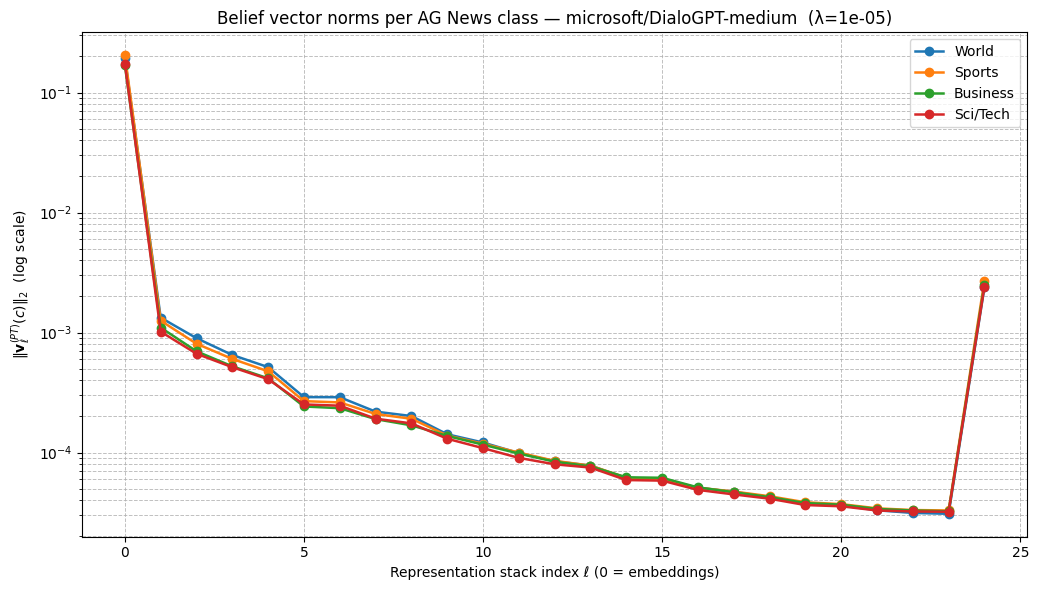


========== gpt2 ==========
Estimating Σ_ℓ^{-1/2} ...
Computing belief vectors v_ℓ(c) per class ...


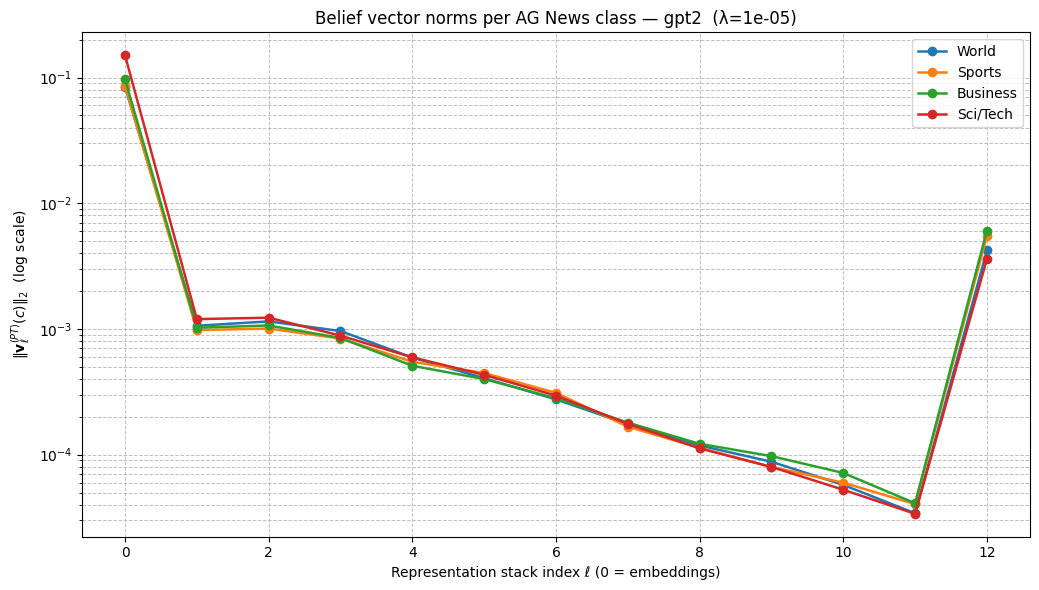


========== TinyLlama/TinyLlama-1.1B-Chat-v1.0 ==========
Estimating Σ_ℓ^{-1/2} ...
Computing belief vectors v_ℓ(c) per class ...


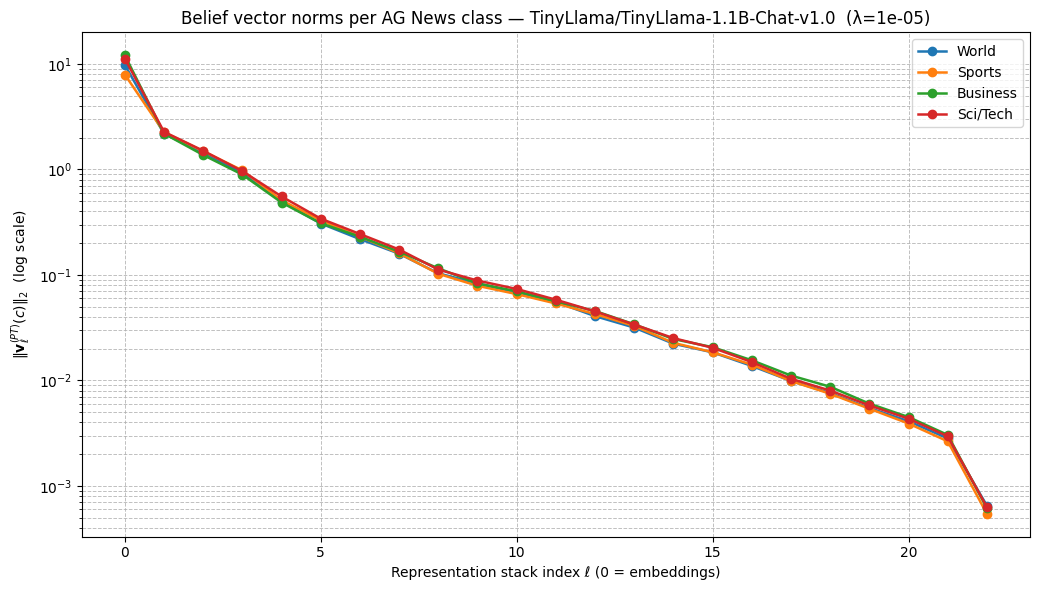

In [ ]:
import math
import random
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple
from contextlib import nullcontext

import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM

# Config
MODELS = [
    "microsoft/DialoGPT-medium",
    "gpt2",
    "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
]

NUM_PER_CLASS = 256            # AG News samples per class (balanced)
BATCH_SIZE    = 2              # small for memory safety (esp. TinyLlama)
MAX_LENGTH    = 192
RIDGE_LAMBDA  = 1e-5           # ridge for Σ^{-1/2}
SEED          = 1234
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

# Forward precision for speed; geometry/pooling in FP32
DTYPE_FW      = (torch.bfloat16 if (DEVICE == "cuda" and torch.cuda.is_bf16_supported())
                 else (torch.float16 if DEVICE == "cuda" else torch.float32))
DTYPE_ACCUM   = torch.float32

# Optionally restrict to a subset of stacks (0=embeddings), e.g. [0, 6, 12]
LAYER_INDICES: Optional[List[int]] = None

# For log plots
EPS_LOG = 1e-16

AGNEWS_CLASS_NAMES = ["World", "Sports", "Business", "Sci/Tech"]

# Repro & basic helpers
def set_seed(seed: int = 1234):
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    if hasattr(torch, "set_float32_matmul_precision"):
        torch.set_float32_matmul_precision("high")

@dataclass
class Batch:
    input_ids: torch.Tensor
    attention_mask: torch.Tensor
    cls: torch.Tensor  # class indices per sample in batch

def collate_fn_builder(tokenizer):
    def collate(batch_texts_labels: List[Tuple[str, int]]) -> Batch:
        texts = [t for (t, y) in batch_texts_labels]
        labels_cls = torch.tensor([y for (t, y) in batch_texts_labels], dtype=torch.long)
        enc = tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors="pt",
        )
        return Batch(input_ids=enc["input_ids"], attention_mask=enc["attention_mask"], cls=labels_cls)
    return collate

# Linear algebra
@torch.no_grad()
def spd_inverse_sqrt(mat: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    eigvals, eigvecs = torch.linalg.eigh(mat.to(DTYPE_ACCUM))
    eigvals = torch.clamp(eigvals, min=eps)
    return eigvecs @ torch.diag(eigvals.rsqrt()) @ eigvecs.transpose(-1, -2)

# Model-agnostic helpers
def get_hidden_size(model) -> int:
    return (getattr(model.config, "n_embd", None)
            or getattr(model.config, "hidden_size", None)
            or model.config.hidden_size)

def get_num_layers(model) -> int:
    return (getattr(model.config, "n_layer", None)
            or getattr(model.config, "num_hidden_layers", None)
            or model.config.num_hidden_layers)

def get_block_list(model) -> List[torch.nn.Module]:
    """
    Return the ordered list of transformer blocks. Works for GPT-2/DialoGPT and LLaMA/TinyLlama.
    """
    if hasattr(model, "transformer") and hasattr(model.transformer, "h"):  # GPT-2 family
        return list(model.transformer.h)
    if hasattr(model, "model") and hasattr(model.model, "layers"):         # LLaMA family
        return list(model.model.layers)
    for attr in ["layers", "h", "blocks"]:
        if hasattr(model, attr):
            m = getattr(model, attr)
            try:
                return list(m)
            except Exception:
                pass
    raise AttributeError("Could not locate transformer block list for this model.")

# Data: AG News balanced subset
def build_agnews_texts(num_per_class: int) -> List[Tuple[str, int]]:
    """
    Returns a list of (text, class_index) with exactly num_per_class per class
    for classes 0..3 in AG News ('World','Sports','Business','Sci/Tech').
    """
    ds = load_dataset("ag_news", split="train")
    buckets = {0: [], 1: [], 2: [], 3: []}
    for ex in ds:
        y = int(ex["label"])
        if y in buckets and len(buckets[y]) < num_per_class:
            buckets[y].append((ex["text"], y))
        if all(len(buckets[k]) >= num_per_class for k in buckets):
            break
    combined: List[Tuple[str, int]] = []
    for k in range(4):
        combined.extend(buckets[k])
    return combined

# Pass 1: estimate Σ_ℓ^{-1/2} with global centering (across all classes)
@torch.no_grad()
def estimate_sigma_inv_sqrts(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    dataloader: DataLoader,
    ridge_lambda: float = RIDGE_LAMBDA,
) -> List[torch.Tensor]:
    model.eval()
    n_layers_total = get_num_layers(model) + 1
    d_model = get_hidden_size(model)

    layer_indices = list(range(n_layers_total)) if LAYER_INDICES is None else list(LAYER_INDICES)
    Sxx = [torch.zeros((d_model, d_model), dtype=DTYPE_ACCUM, device=DEVICE) for _ in layer_indices]
    s   = [torch.zeros((d_model,), dtype=DTYPE_ACCUM, device=DEVICE) for _ in layer_indices]
    N   = [0 for _ in layer_indices]

    torch.backends.cuda.matmul.allow_tf32 = True

    for batch in dataloader:
        input_ids = batch.input_ids.to(DEVICE)
        attention_mask = batch.attention_mask.to(DEVICE)
        if tokenizer.pad_token_id is None:
            tokenizer.pad_token = tokenizer.eos_token
        input_ids = input_ids.masked_fill(attention_mask.eq(0), tokenizer.pad_token_id)

        out = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            use_cache=False,
            return_dict=True,
        )
        hidden_states = out.hidden_states  # tuple len = n_layers+1
        mask = attention_mask.to(torch.bool)
        B, T = mask.shape
        d_model = hidden_states[0].shape[-1]

        for idx_pos, ell in enumerate(layer_indices):
            X = hidden_states[ell]  # (B, T, d)
            X2d = X.view(B * T, d_model)[mask.view(B * T)].to(DTYPE_ACCUM)
            Nb = X2d.shape[0]
            if Nb == 0:
                continue
            Sxx[idx_pos] += X2d.transpose(0, 1) @ X2d
            s[idx_pos]   += X2d.sum(dim=0)
            N[idx_pos]   += Nb

    eye = torch.eye(d_model, dtype=DTYPE_ACCUM, device=DEVICE)
    Sigma_inv_sqrts: List[torch.Tensor] = []
    for idx_pos, ell in enumerate(layer_indices):
        assert N[idx_pos] > 0, f"No tokens for layer {ell}."
        A = (Sxx[idx_pos] - torch.outer(s[idx_pos], s[idx_pos]) / float(N[idx_pos])) / float(N[idx_pos])
        A = 0.5 * (A + A.transpose(0, 1))
        Sigma = A + ridge_lambda * eye
        Sigma_inv_sqrts.append(spd_inverse_sqrt(Sigma))

    if LAYER_INDICES is None:
        return Sigma_inv_sqrts

    full = [torch.eye(d_model, dtype=DTYPE_ACCUM, device=DEVICE) for _ in range(n_layers_total)]
    for idx_pos, ell in enumerate(layer_indices):
        full[ell] = Sigma_inv_sqrts[idx_pos]
    return full

# Pass 2: compute belief vectors v_ℓ(c) for each class using backward hooks
def compute_belief_vectors_by_class(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    dataloader: DataLoader,
    Sigma_inv_sqrts: List[torch.Tensor],
    num_classes: int = 4,
) -> List[List[torch.Tensor]]:
    """
    Returns:
        v_c_list: list over classes c=0..C-1, each a list [v_ℓ(c)] for ℓ=0..L,
                  where v_ℓ(c) ∈ ℝ^d (pooled whitened gradient averaged over samples in class c).
    """
    model.eval()
    # Ensure the forward will build a full graph (no kv-cache detach)
    if hasattr(model.config, "use_cache"):
        model.config.use_cache = False

    n_layers = get_num_layers(model)
    n_layers_total = n_layers + 1
    d_model = get_hidden_size(model)
    layer_indices = list(range(n_layers_total)) if LAYER_INDICES is None else list(LAYER_INDICES)

    # Storage for classwise sums
    v_sum = [[torch.zeros((d_model,), dtype=DTYPE_ACCUM, device=DEVICE) for _ in range(n_layers_total)]
             for _ in range(num_classes)]
    n_samples = [0 for _ in range(num_classes)]

    # Prepare hooks on each transformer block to capture grad wrt inputs/outputs
    blocks = get_block_list(model)
    assert len(blocks) == n_layers, "Block count mismatch."

    grads_in: List[Optional[torch.Tensor]]  = [None] * n_layers     # ∂L/∂X_ℓ     (input to block ℓ)
    grads_out: List[Optional[torch.Tensor]] = [None] * n_layers     # ∂L/∂X_{ℓ+1} (output of block ℓ)
    handles = []

    def make_hook(idx: int):
        def hook(module, grad_input, grad_output):
            if grad_input and (grad_input[0] is not None):
                grads_in[idx] = grad_input[0]
            if grad_output and (grad_output[0] is not None):
                grads_out[idx] = grad_output[0]
        return hook

    for i, blk in enumerate(blocks):
        handles.append(blk.register_full_backward_hook(make_hook(i)))

    torch.backends.cuda.matmul.allow_tf32 = True

    for batch in dataloader:
        # Reset grads buffer for this batch
        for i in range(n_layers):
            grads_in[i] = None
            grads_out[i] = None

        input_ids = batch.input_ids.to(DEVICE)
        attention_mask = batch.attention_mask.to(DEVICE)
        cls_idx = batch.cls.to(torch.long).to(DEVICE)

        if getattr(tokenizer, "pad_token_id", None) is None:
            tokenizer.pad_token = tokenizer.eos_token
        input_ids_for_pad = input_ids.masked_fill(attention_mask.eq(0), tokenizer.pad_token_id)

        # Force grad-enabled region regardless of any prior global setting.
        with torch.enable_grad():
            amp_ctx = (torch.autocast(device_type="cuda", dtype=DTYPE_FW) if DEVICE == "cuda" else nullcontext())
            with amp_ctx:
                out = model(
                    input_ids=input_ids_for_pad,
                    attention_mask=attention_mask,
                    output_hidden_states=False,   # hooks capture grads; hidden_states not needed here
                    use_cache=False,
                    return_dict=True,
                )
                logits = out.logits  # (B, T, V)

                # Verify graph connectivity
                if not logits.requires_grad:
                    raise RuntimeError("Model logits do not require grad. "
                                       "Check that torch.no_grad/torch.inference_mode are not active and use_cache=False.")

                # Standard LM loss on next-token prediction (ignore padding positions)
                shift_logits = logits[:, :-1, :].contiguous().to(torch.float32)  # do CE in FP32
                shift_labels = input_ids[:, 1:].contiguous()
                shift_mask   = attention_mask[:, 1:].contiguous()
                shift_labels = shift_labels.masked_fill(shift_mask.eq(0), -100)

                loss = torch.nn.functional.cross_entropy(
                    shift_logits.view(-1, shift_logits.size(-1)),
                    shift_labels.view(-1),
                    ignore_index=-100,
                    reduction="mean",
                )

            model.zero_grad(set_to_none=True)
            loss.backward()  # triggers hooks to populate grads_in/out

        mask = attention_mask.to(torch.bool)
        B, T = mask.shape
        valid_per_sample = mask.sum(dim=1)                     # (B,)
        nonempty = (valid_per_sample > 0)

        # update sample counts per class for nonempty samples
        if nonempty.any():
            for c in range(num_classes):
                n_samples[c] += int(((cls_idx == c) & nonempty).sum().item())

        # Build G_list[0..n_layers] for this batch:
        #   G_list[ℓ] = grads_in[ℓ] for ℓ=0..n_layers-1
        #   G_list[n_layers] = grads_out[n_layers-1]
        G_list: List[Optional[torch.Tensor]] = [None] * n_layers_total
        for ell in range(n_layers):
            G_list[ell] = grads_in[ell]
        G_list[n_layers] = grads_out[n_layers - 1]

        # Sanity + pool/accumulate per class
        for ell in layer_indices:
            G = G_list[ell]
            if G is None:
                raise RuntimeError(f"Gradient for layer index {ell} is None (batch size {B}, T {T}).")
            # Whiten in intrinsic metric
            Sinv = Sigma_inv_sqrts[ell]
            G_wh = torch.matmul(G.to(DTYPE_ACCUM), Sinv)       # (B, T, d)

            # token-pool after whitening: mean over valid tokens per sample
            sums = (G_wh * mask.unsqueeze(-1)).sum(dim=1)      # (B, d)
            counts = valid_per_sample.clamp_min(1).unsqueeze(-1).to(DTYPE_ACCUM)
            pooled = sums / counts                             # (B, d)

            if nonempty.any():
                for c in range(num_classes):
                    idx_c = (cls_idx == c) & nonempty
                    if idx_c.any():
                        v_sum[c][ell] += pooled[idx_c].sum(dim=0)

        # cleanup per batch
        del out, logits, shift_logits, shift_labels, loss
        model.zero_grad(set_to_none=True)
        if DEVICE == "cuda":
            torch.cuda.synchronize()

    # Remove hooks
    for h in handles:
        h.remove()

    # finalize averages
    v_c_list: List[List[torch.Tensor]] = []
    for c in range(num_classes):
        assert n_samples[c] > 0, f"No nonempty samples for class {c}."
        v_list_c = [v_sum[c][ell] / float(n_samples[c]) for ell in range(n_layers_total)]
        v_c_list.append(v_list_c)
    return v_c_list

# Per-model run: build Σ^{-1/2}, compute v_ℓ(c), plot norms per class
def run_for_model(model_name: str, data: List[Tuple[str, int]]):
    print(f"\n========== {model_name} ==========")

    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, trust_remote_code=True)
    if tokenizer.pad_token_id is None:
        tokenizer.pad_token = tokenizer.eos_token

    cfg = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
    cfg.output_hidden_states = True  # used in Σ pass
    if hasattr(cfg, "use_cache"):
        cfg.use_cache = False
    model = AutoModelForCausalLM.from_pretrained(model_name, config=cfg, trust_remote_code=True).to(DEVICE).eval()

    # Make sure params can carry grad
    for p in model.parameters():
        if not p.requires_grad:
            p.requires_grad_(True)

    collate = collate_fn_builder(tokenizer)
    loader = DataLoader(
        data,
        batch_size=BATCH_SIZE,
        shuffle=False,
        drop_last=False,
        num_workers=2 if DEVICE == "cuda" else 0,
        pin_memory=(DEVICE == "cuda"),
        collate_fn=collate,
    )

    # Σ^{-1/2} per layer (global across all classes)
    print("Estimating Σ_ℓ^{-1/2} ...")
    Sigma_inv_sqrts = estimate_sigma_inv_sqrts(model, tokenizer, loader, ridge_lambda=RIDGE_LAMBDA)

    # Belief vectors per class (hooks-based grads)
    print("Computing belief vectors v_ℓ(c) per class ...")
    v_by_class = compute_belief_vectors_by_class(model, tokenizer, loader, Sigma_inv_sqrts, num_classes=4)

    # Prepare per-class norms across layers
    n_layers_total = get_num_layers(model) + 1
    x = list(range(n_layers_total))
    norms_by_class: Dict[int, List[float]] = {}
    for c in range(4):
        norms = [float(torch.linalg.norm(v_by_class[c][ell]).item()) for ell in range(n_layers_total)]
        norms_by_class[c] = [max(EPS_LOG, v) for v in norms]

    # Plot (one figure per model, four class curves in log scale)
    plt.figure(figsize=(10.5, 6.0))
    for c in range(4):
        plt.plot(x, norms_by_class[c], marker="o", linewidth=1.8, label=AGNEWS_CLASS_NAMES[c])
    plt.yscale("log")
    plt.xlabel("Representation stack index ℓ (0 = embeddings)")
    plt.ylabel(r"$\|\mathbf{v}^{(PT)}_\ell(c)\|_2$  (log scale)")
    plt.title(f"Belief vector norms per AG News class — {model_name}  (λ={RIDGE_LAMBDA})")
    plt.grid(True, which="both", linestyle="--", linewidth=0.7, alpha=0.8)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Free memory between models
    del model
    if DEVICE == "cuda":
        torch.cuda.empty_cache()

# -------------------------------
# Entry
# -------------------------------
def main():
    set_seed(SEED)
    data = build_agnews_texts(NUM_PER_CLASS)  # balanced per class
    for model_name in MODELS:
        run_for_model(model_name, data)

if __name__ == "__main__":
    main()


## Concreteness


========== microsoft/DialoGPT-medium ==========
Estimating Σ_ℓ^{-1/2} ...
Computing belief vectors v_ℓ(c) for Philosophy vs Business ...


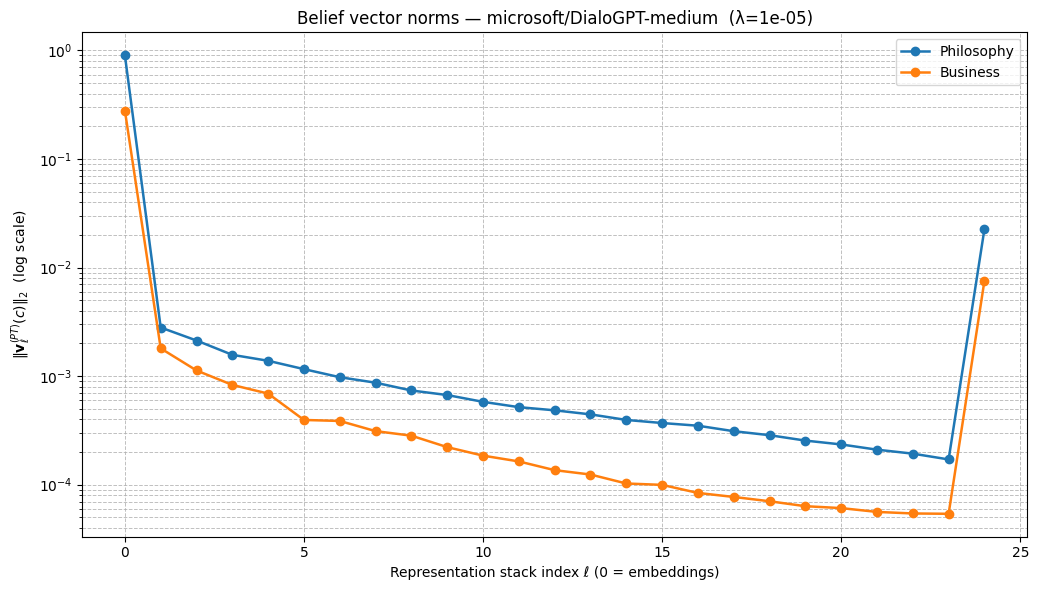


========== gpt2 ==========
Estimating Σ_ℓ^{-1/2} ...
Computing belief vectors v_ℓ(c) for Philosophy vs Business ...


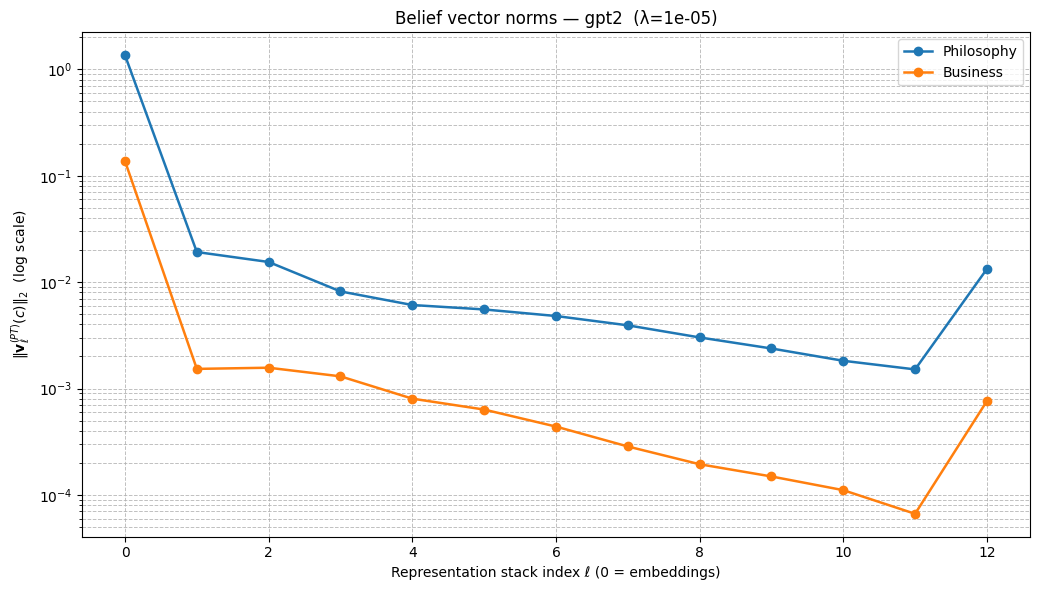


========== TinyLlama/TinyLlama-1.1B-Chat-v1.0 ==========
Estimating Σ_ℓ^{-1/2} ...
Computing belief vectors v_ℓ(c) for Philosophy vs Business ...


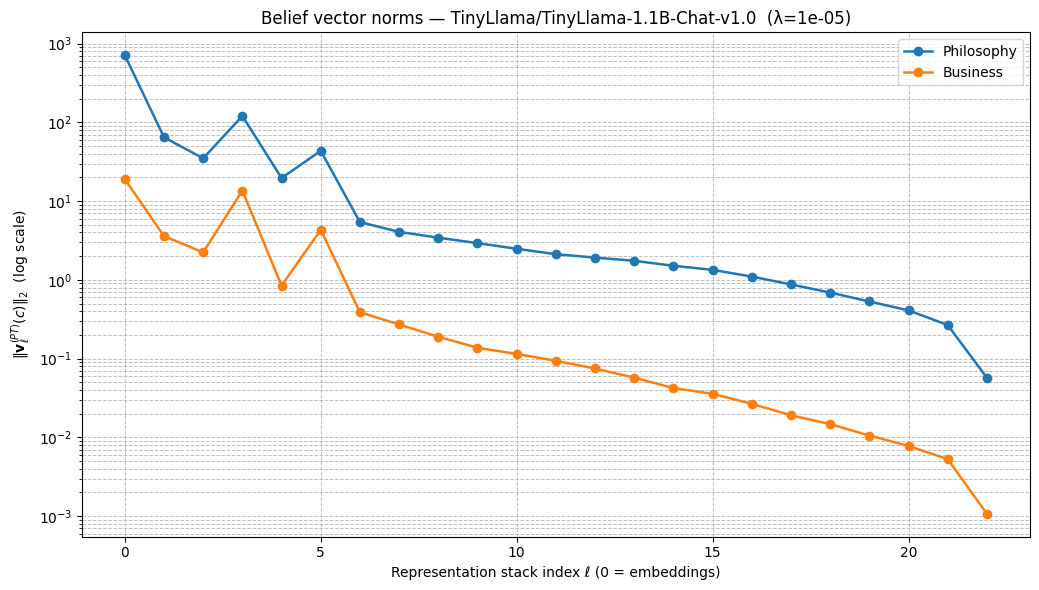

In [ ]:
import math
import random
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple
from contextlib import nullcontext

import pandas as pd
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM

# Config
MODELS = [
    "microsoft/DialoGPT-medium",
    "gpt2",
    "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
]

# Per-class sample caps (increase if you have VRAM/CPU time)
NUM_PHILOSOPHY = 256
NUM_BUSINESS   = 256

BATCH_SIZE    = 2              # keep small for memory safety on TinyLlama
MAX_LENGTH    = 192
RIDGE_LAMBDA  = 1e-5           # ridge for Σ^{-1/2}
SEED          = 1234
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

# Forward precision for throughput; all metric math (Σ, whitening, pooling) in FP32
DTYPE_FW      = (torch.bfloat16 if (DEVICE == "cuda" and torch.cuda.is_bf16_supported())
                 else (torch.float16 if DEVICE == "cuda" else torch.float32))
DTYPE_ACCUM   = torch.float32

# Optionally restrict to subset of stacks (0=embeddings). None = all layers incl. embeddings.
LAYER_INDICES: Optional[List[int]] = None

# For log plots
EPS_LOG = 1e-16

CLASS_NAMES = ["Philosophy", "Business"]  # c=0, c=1

# Repro & basic helpers
def set_seed(seed: int = 1234):
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    if hasattr(torch, "set_float32_matmul_precision"):
        torch.set_float32_matmul_precision("high")

@dataclass
class Batch:
    input_ids: torch.Tensor
    attention_mask: torch.Tensor
    cls: torch.Tensor  # class indices per sample in batch

def collate_fn_builder(tokenizer):
    def collate(batch_texts_labels: List[Tuple[str, int]]) -> Batch:
        texts = [t for (t, y) in batch_texts_labels]
        labels_cls = torch.tensor([y for (t, y) in batch_texts_labels], dtype=torch.long)
        enc = tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors="pt",
        )
        return Batch(input_ids=enc["input_ids"], attention_mask=enc["attention_mask"], cls=labels_cls)
    return collate

# Linear algebra
@torch.no_grad()
def spd_inverse_sqrt(mat: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    eigvals, eigvecs = torch.linalg.eigh(mat.to(DTYPE_ACCUM))
    eigvals = torch.clamp(eigvals, min=eps)
    return eigvecs @ torch.diag(eigvals.rsqrt()) @ eigvecs.transpose(-1, -2)

# Model-agnostic helpers
def get_hidden_size(model) -> int:
    return (getattr(model.config, "n_embd", None)
            or getattr(model.config, "hidden_size", None)
            or model.config.hidden_size)

def get_num_layers(model) -> int:
    return (getattr(model.config, "n_layer", None)
            or getattr(model.config, "num_hidden_layers", None)
            or model.config.num_hidden_layers)

def get_block_list(model) -> List[torch.nn.Module]:
    """
    Return the ordered list of transformer blocks. Works for GPT-2/DialoGPT and LLaMA/TinyLlama.
    """
    if hasattr(model, "transformer") and hasattr(model.transformer, "h"):  # GPT-2 family
        return list(model.transformer.h)
    if hasattr(model, "model") and hasattr(model.model, "layers"):         # LLaMA family
        return list(model.model.layers)
    for attr in ["layers", "h", "blocks"]:
        if hasattr(model, attr):
            m = getattr(model, attr)
            try:
                return list(m)
            except Exception:
                pass
    raise AttributeError("Could not locate transformer block list for this model.")

# Data: Philosophy vs Business
def select_text_series(df: pd.DataFrame, preferred_order: List[str]) -> pd.Series:
    # Prefer specific columns (if present), else pick the longest text-like column.
    for col in preferred_order:
        if col in df.columns:
            return df[col].astype(str)
    # Fallback: choose object-like column with largest avg length
    obj_cols = [c for c in df.columns if df[c].dtype == "object"]
    if obj_cols:
        lens = {c: df[c].astype(str).str.len().mean() for c in obj_cols}
        best = max(lens, key=lens.get)
        return df[best].astype(str)
    # As a last resort, stringify the whole row
    return df.apply(lambda r: " ".join(map(str, r.values)), axis=1)

def build_philosophy_business_pairs(n_phil: int, n_biz: int) -> List[Tuple[str, int]]:
    # Philosophy dataset
    ph = load_dataset("hugfaceguy0001/stanford_plato", split="train")
    ph_df = ph.to_pandas() if hasattr(ph, "to_pandas") else pd.DataFrame(ph)
    # Drop user-mentioned columns if present
    for col in ["pubinfo", "shorturl", "bibliography", "related_entries"]:
        if col in ph_df.columns:
            ph_df = ph_df.drop(columns=[col])
    # Choose a sensible text column
    ph_text = select_text_series(
        ph_df,
        preferred_order=["content", "text", "body", "entry", "article", "full_text", "essay", "summary", "title"]
    ).fillna("").astype(str)

    # AG News Business (label==2)
    ag = load_dataset("ag_news", split="train")
    ag_df = ag.to_pandas() if hasattr(ag, "to_pandas") else pd.DataFrame(ag)
    ag_df = ag_df[ag_df["label"] == 2].copy()  # Business
    # Many AG News versions have 'text' (or 'description') and sometimes 'title'
    # Prefer "title + text/description" if available
    if "text" in ag_df.columns and "title" in ag_df.columns:
        ag_text = ("Title: " + ag_df["title"].astype(str) + "\nContent: " + ag_df["text"].astype(str)).fillna("")
    elif "description" in ag_df.columns and "title" in ag_df.columns:
        ag_text = ("Title: " + ag_df["title"].astype(str) + "\nContent: " + ag_df["description"].astype(str)).fillna("")
    else:
        ag_text = select_text_series(ag_df, preferred_order=["text", "description", "content", "article", "body"]).fillna("").astype(str)

    # Trim to requested counts
    ph_list = ph_text.head(n_phil).tolist()
    biz_list = ag_text.head(n_biz).tolist()

    # Build combined (text, class_idx) pairs
    pairs: List[Tuple[str, int]] = []
    pairs += [(t, 0) for t in ph_list]      # Philosophy -> class 0
    pairs += [(t, 1) for t in biz_list]     # Business   -> class 1
    return pairs

# Pass 1: estimate Σ_ℓ^{-1/2} with global centering (across both classes)
@torch.no_grad()
def estimate_sigma_inv_sqrts(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    dataloader: DataLoader,
    ridge_lambda: float = RIDGE_LAMBDA,
) -> List[torch.Tensor]:
    model.eval()
    n_layers_total = get_num_layers(model) + 1
    d_model = get_hidden_size(model)

    layer_indices = list(range(n_layers_total)) if LAYER_INDICES is None else list(LAYER_INDICES)
    Sxx = [torch.zeros((d_model, d_model), dtype=DTYPE_ACCUM, device=DEVICE) for _ in layer_indices]
    s   = [torch.zeros((d_model,), dtype=DTYPE_ACCUM, device=DEVICE) for _ in layer_indices]
    N   = [0 for _ in layer_indices]

    torch.backends.cuda.matmul.allow_tf32 = True

    for batch in dataloader:
        input_ids = batch.input_ids.to(DEVICE)
        attention_mask = batch.attention_mask.to(DEVICE)
        if tokenizer.pad_token_id is None:
            tokenizer.pad_token = tokenizer.eos_token
        input_ids = input_ids.masked_fill(attention_mask.eq(0), tokenizer.pad_token_id)

        out = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            use_cache=False,
            return_dict=True,
        )
        hidden_states = out.hidden_states  # tuple len = n_layers+1
        mask = attention_mask.to(torch.bool)
        B, T = mask.shape
        d_model = hidden_states[0].shape[-1]

        for idx_pos, ell in enumerate(layer_indices):
            X = hidden_states[ell]  # (B, T, d)
            X2d = X.view(B * T, d_model)[mask.view(B * T)].to(DTYPE_ACCUM)
            Nb = X2d.shape[0]
            if Nb == 0:
                continue
            Sxx[idx_pos] += X2d.transpose(0, 1) @ X2d
            s[idx_pos]   += X2d.sum(dim=0)
            N[idx_pos]   += Nb

    eye = torch.eye(d_model, dtype=DTYPE_ACCUM, device=DEVICE)
    Sigma_inv_sqrts: List[torch.Tensor] = []
    for idx_pos, ell in enumerate(layer_indices):
        assert N[idx_pos] > 0, f"No tokens for layer {ell}."
        A = (Sxx[idx_pos] - torch.outer(s[idx_pos], s[idx_pos]) / float(N[idx_pos])) / float(N[idx_pos])
        A = 0.5 * (A + A.transpose(0, 1))
        Sigma = A + ridge_lambda * eye
        Sigma_inv_sqrts.append(spd_inverse_sqrt(Sigma))

    if LAYER_INDICES is None:
        return Sigma_inv_sqrts

    # Expand to full stack length for convenience
    n_layers_total = get_num_layers(model) + 1
    full = [torch.eye(d_model, dtype=DTYPE_ACCUM, device=DEVICE) for _ in range(n_layers_total)]
    for idx_pos, ell in enumerate(layer_indices):
        full[ell] = Sigma_inv_sqrts[idx_pos]
    return full

# Pass 2: compute belief vectors v_ℓ(c) for each class using backward hooks
def compute_belief_vectors_by_class(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    dataloader: DataLoader,
    Sigma_inv_sqrts: List[torch.Tensor],
    num_classes: int = 2,
) -> List[List[torch.Tensor]]:
    """
    Returns:
        v_c_list: list over classes c=0..C-1, each a list [v_ℓ(c)] for ℓ=0..L,
                  where v_ℓ(c) ∈ ℝ^d (pooled whitened gradient averaged over samples in class c).
    """
    model.eval()
    # Ensure full graph (no kv-cache detaches)
    if hasattr(model.config, "use_cache"):
        model.config.use_cache = False

    n_layers = get_num_layers(model)
    n_layers_total = n_layers + 1
    d_model = get_hidden_size(model)
    layer_indices = list(range(n_layers_total)) if LAYER_INDICES is None else list(LAYER_INDICES)

    # Storage for classwise sums
    v_sum = [[torch.zeros((d_model,), dtype=DTYPE_ACCUM, device=DEVICE) for _ in range(n_layers_total)]
             for _ in range(num_classes)]
    n_samples = [0 for _ in range(num_classes)]

    # Prepare hooks on each transformer block to capture grad wrt inputs/outputs
    blocks = get_block_list(model)
    assert len(blocks) == n_layers, "Block count mismatch."

    grads_in:  List[Optional[torch.Tensor]] = [None] * n_layers     # ∂L/∂X_ℓ     (input to block ℓ)
    grads_out: List[Optional[torch.Tensor]] = [None] * n_layers     # ∂L/∂X_{ℓ+1} (output of block ℓ)
    handles = []

    def make_hook(idx: int):
        def hook(module, grad_input, grad_output):
            if grad_input and (grad_input[0] is not None):
                grads_in[idx] = grad_input[0]
            if grad_output and (grad_output[0] is not None):
                grads_out[idx] = grad_output[0]
        return hook

    for i, blk in enumerate(blocks):
        handles.append(blk.register_full_backward_hook(make_hook(i)))

    torch.backends.cuda.matmul.allow_tf32 = True

    for batch in dataloader:
        # Reset grads buffer for this batch
        for i in range(n_layers):
            grads_in[i] = None
            grads_out[i] = None

        input_ids = batch.input_ids.to(DEVICE)
        attention_mask = batch.attention_mask.to(DEVICE)
        cls_idx = batch.cls.to(torch.long).to(DEVICE)

        if getattr(tokenizer, "pad_token_id", None) is None:
            tokenizer.pad_token = tokenizer.eos_token
        input_ids_pad = input_ids.masked_fill(attention_mask.eq(0), tokenizer.pad_token_id)

        # Build loss under grad-enabled context (no inference_mode!)
        with torch.enable_grad():
            amp_ctx = (torch.autocast(device_type="cuda", dtype=DTYPE_FW) if DEVICE == "cuda" else nullcontext())
            with amp_ctx:
                out = model(
                    input_ids=input_ids_pad,
                    attention_mask=attention_mask,
                    output_hidden_states=False,   # hooks capture grads; hidden_states not needed here
                    use_cache=False,
                    return_dict=True,
                )
                logits = out.logits  # (B, T, V)
                if not logits.requires_grad:
                    raise RuntimeError("Logits do not require grad. Ensure use_cache=False and no global no_grad/inference_mode.")

                # Standard masked next-token cross-entropy (do CE in FP32)
                shift_logits = logits[:, :-1, :].contiguous().to(torch.float32)
                shift_labels = input_ids[:, 1:].contiguous()
                shift_mask   = attention_mask[:, 1:].contiguous()
                shift_labels = shift_labels.masked_fill(shift_mask.eq(0), -100)

                loss = torch.nn.functional.cross_entropy(
                    shift_logits.view(-1, shift_logits.size(-1)),
                    shift_labels.view(-1),
                    ignore_index=-100,
                    reduction="mean",
                )

            model.zero_grad(set_to_none=True)
            loss.float().backward()  # triggers hooks to populate grads_in/out

        mask = attention_mask.to(torch.bool)
        B, T = mask.shape
        valid_per_sample = mask.sum(dim=1)                     # (B,)
        nonempty = (valid_per_sample > 0)

        # Update sample counts per class for nonempty samples
        if nonempty.any():
            for c in range(num_classes):
                n_samples[c] += int(((cls_idx == c) & nonempty).sum().item())

        G_list: List[Optional[torch.Tensor]] = [None] * n_layers_total
        for ell in range(n_layers):
            G_list[ell] = grads_in[ell]
        G_list[n_layers] = grads_out[n_layers - 1]

        # Sanity + pool/accumulate per class
        for ell in layer_indices:
            G = G_list[ell]
            if G is None:
                raise RuntimeError(f"Gradient for layer index {ell} is None (batch size {B}, T {T}).")

            # Whiten in intrinsic metric
            Sinv = Sigma_inv_sqrts[ell]
            G_wh = torch.matmul(G.to(DTYPE_ACCUM), Sinv)       # (B, T, d)

            # token-pool after whitening: mean over valid tokens per sample
            sums = (G_wh * mask.unsqueeze(-1)).sum(dim=1)      # (B, d)
            counts = valid_per_sample.clamp_min(1).unsqueeze(-1).to(DTYPE_ACCUM)
            pooled = sums / counts                             # (B, d)

            if nonempty.any():
                for c in range(num_classes):
                    idx_c = (cls_idx == c) & nonempty
                    if idx_c.any():
                        v_sum[c][ell] += pooled[idx_c].sum(dim=0)

        # cleanup per batch
        del out, logits, shift_logits, shift_labels, loss
        model.zero_grad(set_to_none=True)
        if DEVICE == "cuda":
            torch.cuda.synchronize()

    # Remove hooks
    for h in handles:
        h.remove()

    # finalize averages
    v_c_list: List[List[torch.Tensor]] = []
    for c in range(num_classes):
        assert n_samples[c] > 0, f"No nonempty samples for class {c}."
        v_list_c = [v_sum[c][ell] / float(n_samples[c]) for ell in range(n_layers_total)]
        v_c_list.append(v_list_c)
    return v_c_list

# Per-model run: build Σ^{-1/2}, compute v_ℓ(c), plot norms
def run_for_model(model_name: str, data: List[Tuple[str, int]]):
    print(f"\n========== {model_name} ==========")

    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, trust_remote_code=True)
    if tokenizer.pad_token_id is None:
        tokenizer.pad_token = tokenizer.eos_token

    cfg = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
    cfg.output_hidden_states = True   # required for Σ pass
    if hasattr(cfg, "use_cache"):
        cfg.use_cache = False
    model = AutoModelForCausalLM.from_pretrained(model_name, config=cfg, trust_remote_code=True).to(DEVICE).eval()

    collate = collate_fn_builder(tokenizer)
    loader = DataLoader(
        data,
        batch_size=BATCH_SIZE,
        shuffle=False,
        drop_last=False,
        num_workers=2 if DEVICE == "cuda" else 0,
        pin_memory=(DEVICE == "cuda"),
        collate_fn=collate,
    )

    # Σ^{-1/2} per layer (global across both classes)
    print("Estimating Σ_ℓ^{-1/2} ...")
    Sigma_inv_sqrts = estimate_sigma_inv_sqrts(model, tokenizer, loader, ridge_lambda=RIDGE_LAMBDA)

    # Belief vectors per class (hooks-based grads)
    print("Computing belief vectors v_ℓ(c) for Philosophy vs Business ...")
    v_by_class = compute_belief_vectors_by_class(model, tokenizer, loader, Sigma_inv_sqrts, num_classes=2)

    # Prepare per-class norms across layers
    n_layers_total = get_num_layers(model) + 1
    x = list(range(n_layers_total))
    norms_by_class: Dict[int, List[float]] = {}
    for c in range(2):
        norms = [float(torch.linalg.norm(v_by_class[c][ell]).item()) for ell in range(n_layers_total)]
        norms_by_class[c] = [max(EPS_LOG, v) for v in norms]

    # Plot (one figure per model, two class curves in log scale)
    plt.figure(figsize=(10.5, 6.0))
    for c in range(2):
        plt.plot(x, norms_by_class[c], marker="o", linewidth=1.8, label=CLASS_NAMES[c])
    plt.yscale("log")
    plt.xlabel("Representation stack index ℓ (0 = embeddings)")
    plt.ylabel(r"$\|\mathbf{v}^{(PT)}_\ell(c)\|_2$  (log scale)")
    plt.title(f"Belief vector norms — {model_name}  (λ={RIDGE_LAMBDA})")
    plt.grid(True, which="both", linestyle="--", linewidth=0.7, alpha=0.8)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Free memory between models
    del model
    if DEVICE == "cuda":
        torch.cuda.empty_cache()

# Entry
def main():
    set_seed(SEED)
    # Build a combined dataset with labels: 0=Philosophy, 1=Business
    data = build_philosophy_business_pairs(NUM_PHILOSOPHY, NUM_BUSINESS)
    # Shuffle so Σ-pass mixes classes well
    random.shuffle(data)
    for model_name in MODELS:
        run_for_model(model_name, data)

if __name__ == "__main__":
    main()